# Solar System Particle Dynamics Simulation with AMUSE

This notebook simulates particle dynamics in our Solar System, focusing on asteroid-like test particles.

**Based on the TOI-178 simulation framework but adapted for Solar System studies**

## Study Overview

Our Solar System provides an excellent test case with:
- **4 major planets** with well-known orbital parameters
- **Asteroid belt** between Mars and Jupiter (2.1 - 3.3 AU)
- **Jupiter Trojans** at L4 and L5 Lagrange points
- **Kirkwood gaps** in the asteroid belt due to Jupiter resonances

### Key Features to Study:
1. **Asteroid belt structure** and gaps due to Jupiter resonances (3:1, 5:2, 7:3, 2:1)
2. **Trojan asteroid regions** around Jupiter's L4/L5 points
3. **Planet-crossing asteroids** and their stability
4. **Long-term orbital evolution** and particle survival
5. **Resonance effects** throughout the Solar System

### Simulation Goals:
- N-body integration of test particles throughout the Solar System
- Identify stable regions (asteroid belt, Trojan points)
- Analyze resonant gaps (Kirkwood gaps)
- Study particle dynamics on different timescales

In [40]:
%%bash
# Check and install required AMUSE components
PACKAGES="mpi4py amuse-framework amuse-huayno amuse-ph4"
pip show amuse-devel && exit 0
for package in ${PACKAGES}
do
  pip show ${package} || pip install ${package}
done

Name: amuse-devel
Version: 2023.5.2.dev101+g93390091c
Summary: The Astrophysical Multipurpose Software Environment
Home-page: http://www.amusecode.org/
Author: The AMUSE team
Author-email: info@amusecode.org
License: Apache License 2.0
Location: /Users/zoutongshen/miniforge3/envs/Amuse-env/lib/python3.12/site-packages
Editable project location: /Users/zoutongshen/amuse-src
Requires: docutils, h5py, numpy, pip, pytest, setuptools, setuptools_scm, wheel
Required-by: 
Version: 2023.5.2.dev101+g93390091c
Summary: The Astrophysical Multipurpose Software Environment
Home-page: http://www.amusecode.org/
Author: The AMUSE team
Author-email: info@amusecode.org
License: Apache License 2.0
Location: /Users/zoutongshen/miniforge3/envs/Amuse-env/lib/python3.12/site-packages
Editable project location: /Users/zoutongshen/amuse-src
Requires: docutils, h5py, numpy, pip, pytest, setuptools, setuptools_scm, wheel
Required-by: 


In [41]:
# AMUSE optimizations for notebook environment
import os
os.environ["OMPI_MCA_rmaps_base_oversubscribe"] = "true"

from amuse.support import options
options.GlobalOptions.instance().override_value_for_option("polling_interval_in_milliseconds", 10)

## 1. Setup and Imports

In [42]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

from amuse.units import units, constants, nbody_system
from amuse.datamodel import Particles
from amuse.community.huayno.interface import Huayno
from amuse.ext.orbital_elements import orbital_elements_from_binary, new_binary_from_orbital_elements

print("AMUSE modules loaded successfully!")

AMUSE modules loaded successfully!


## 2. Define Solar System Parameters

Our Solar System with 8 planets and the Sun. All values are well-established astronomical data.

**Planet order**: Mercury, Venus, Earth, Mars, Jupiter, Saturn, Uranus, Neptune

In [43]:
# Solar System - Sun properties
star_mass = 1.0 | units.MSun  # Sun
star_radius = 1.0 | units.RSun

# Planet properties (standard Solar System data)
# Mass in Earth masses, semi-major axis in AU, eccentricity, inclination in degrees
# NOTE: Mercury removed to focus on asteroid belt dynamics
planet_data = {
    # 'Venus':   {'mass': 0.815,   'a': 0.723, 'e': 0.007, 'i': 3.39},
    # 'Earth':   {'mass': 1.000,   'a': 1.000, 'e': 0.017, 'i': 0.00},
    # 'Mars':    {'mass': 0.107,   'a': 1.524, 'e': 0.093, 'i': 1.85},
    'Jupiter': {'mass': 317.8,   'a': 4.8, 'e': 0.049, 'i': 1.30}, #drifting!
    'Saturn':  {'mass': 95.16,   'a': 9.537, 'e': 0.057, 'i': 2.49},
    'Uranus':  {'mass': 14.54,   'a': 19.19, 'e': 0.046, 'i': 0.77},
    'Neptune': {'mass': 17.15,   'a': 30.07, 'e': 0.010, 'i': 1.77},
}

print(f"Star mass: {star_mass}")
print(f"Number of planets: {len(planet_data)}")
print(f"\n** Solar System Structure **")
# print(f"  Inner planets: Venus, Earth, Mars")
print(f"  Asteroid belt: ~2.1 - 3.3 AU (between Mars and Jupiter)")
print(f"  Outer planets: Jupiter, Saturn, Uranus, Neptune")
print(f"  NOTE: Mercury excluded for better asteroid belt focus")
print(f"\nPlanetary data:")
for name, data in planet_data.items():
    print(f"  {name:8s}: {data['mass']:6.2f} M_Earth, a = {data['a']:5.3f} AU, e = {data['e']:.3f}, i = {data['i']:4.2f}°")

Star mass: 1.0 MSun
Number of planets: 4

** Solar System Structure **
  Asteroid belt: ~2.1 - 3.3 AU (between Mars and Jupiter)
  Outer planets: Jupiter, Saturn, Uranus, Neptune
  NOTE: Mercury excluded for better asteroid belt focus

Planetary data:
  Jupiter : 317.80 M_Earth, a = 4.800 AU, e = 0.049, i = 1.30°
  Saturn  :  95.16 M_Earth, a = 9.537 AU, e = 0.057, i = 2.49°
  Uranus  :  14.54 M_Earth, a = 19.190 AU, e = 0.046, i = 0.77°
  Neptune :  17.15 M_Earth, a = 30.070 AU, e = 0.010, i = 1.77°


## 3. Create the Solar System

In [44]:
def create_solar_system():
    """Create the Solar System with Sun and 7 planets (Mercury excluded)."""
    
    # Create the Sun
    sun = Particles(1)
    sun.mass = star_mass
    sun.radius = star_radius
    sun.position = [0, 0, 0] | units.AU
    sun.velocity = [0, 0, 0] | units.km / units.s
    
    # Create planets
    planets = Particles()
    
    for name, data in planet_data.items():
        # Convert planet properties to AMUSE units
        planet_mass = data['mass'] | units.MEarth
        semi_major_axis = data['a'] | units.AU
        eccentricity = data['e']
        inclination = data['i'] | units.deg
        
        # Random initial positions (for realistic orbital phases)
        true_anomaly = (360.0 * np.random.random()) | units.deg
        longitude_of_ascending_node = (360.0 * np.random.random()) | units.deg
        argument_of_periapsis = (360.0 * np.random.random()) | units.deg
        
        # Generate binary (Sun-planet pair) from orbital elements
        binary = new_binary_from_orbital_elements(
            star_mass,
            planet_mass,
            semi_major_axis,
            eccentricity,
            true_anomaly,
            inclination,
            longitude_of_ascending_node,
            argument_of_periapsis,
            G=constants.G
        )
        
        # The second particle is the planet (first is Sun at origin)
        planet = Particles(1)
        planet.mass = binary[1].mass
        planet.position = binary[1].position
        planet.velocity = binary[1].velocity
        
        # Set planet radius (approximate)
        if name in ['Venus', 'Earth', 'Mars']:
            planet.radius = 0.5 | units.REarth  # Rocky planets
        else:
            planet.radius = 4.0 | units.REarth   # Gas giants (approximate)
        
        planet.name = name
        planets.add_particle(planet)
    
    # Combine Sun and planets
    system = Particles()
    system.add_particle(sun)
    system.add_particles(planets)
    
    # Move to center of mass frame
    system.move_to_center()
    
    return system

# Create the system
np.random.seed(42)  # For reproducible planet positions
bodies = create_solar_system()
print(f"Created Solar System with {len(bodies)} bodies")
# print(f"Total mass: {bodies.total_mass().in_(units.MSun):.4f} MSun")
# print(f"\nPlanetary orbits:")
# for i, planet in enumerate(bodies[1:]):
#     r = planet.position.length().in_(units.AU)
#     v = planet.velocity.length().in_(units.km/units.s)
#     #print(f"  {planet.name:8s}: r = {r:5.2f} AU, v = {v:5.1f} km/s")

Created Solar System with 5 bodies


/Users/zoutongshen/miniforge3/envs/Amuse-env/lib/python3.12/site-packages/amuse/ext/orbital_elements.py:344: UserWarning: new_binary_from_orbital_elements is deprecated, use generate_binaries instead
  warnings.warn(


In [45]:
# For this simulation, we only need Sun + Jupiter
# Extract Sun (index 0) and Jupiter (should be in the list)
sun = bodies[0:1]  # Sun

# Find Jupiter in the bodies
jupiter = None
for i, body in enumerate(bodies[1:], start=1):
    if hasattr(body, 'name') and 'Jupiter' in body.name:
        jupiter = bodies[i:i+1]
        print(f"Found Jupiter at index {i}: {body.name}")
        break

if jupiter is None:
    raise ValueError("Jupiter not found in bodies!")

# Create the massive_bodies set with only Sun + Jupiter
bodies = Particles()
bodies.add_particles(sun)
bodies.add_particles(jupiter)

# Set names explicitly
bodies[0].name = "Sun"
bodies[1].name = "Jupiter"

print(f"\n✓ Massive bodies configured: {len(bodies)} bodies (Sun + Jupiter)")
print(f"  Sun mass: {bodies[0].mass.value_in(units.MSun):.6f} MSun")
print(f"  Jupiter mass: {bodies[1].mass.value_in(units.MJupiter):.4f} MJupiter")
print(f"  Jupiter distance: {bodies[1].position.length().value_in(units.AU):.2f} AU")

Found Jupiter at index 1: Jupiter

✓ Massive bodies configured: 2 bodies (Sun + Jupiter)
  Sun mass: 1.000000 MSun
  Jupiter mass: 0.9996 MJupiter
  Jupiter distance: 4.95 AU


## 4. Add Test Particles (Asteroids)

We'll add test particles to simulate:
1. **Asteroid belt** particles (2.1 - 3.3 AU) to study Kirkwood gaps
2. **Jupiter Trojans** near L4/L5 Lagrange points
3. **Planet-crossing asteroids** for stability analysis
4. **Outer Solar System** objects

Test particles represent asteroids, comets, or debris - very low mass to not affect planetary orbits.

In [46]:
def add_test_particles_for_migration(
    nparticles=10000, 
    amin=2.0, 
    amax=3.5, 
    mass=0,
    jupiter_a=4.8  # NEW: Jupiter's initial semi-major axis
):
    """
    Add test particles/asteroids adapted for Jupiter migration scenario.
    
    Parameters:
    -----------
    jupiter_a : float
        Jupiter's semi-major axis in AU (e.g., 4.8 for initial position)
    """
    test_particles = Particles(nparticles)
    
    np.random.seed(123)
    
    for i, particle in enumerate(test_particles):
        # Semi-major axis distribution
        if i < nparticles * 0.7:
            # 70% in asteroid belt (2.1 - 3.3 AU)
            a = (2.1 + (3.3 - 2.1) * np.random.random()) | units.AU
            
        elif i < nparticles * 0.9:
            # 20% in Jupiter Trojan regions (L4/L5 at Jupiter's distance)
            # KEY CHANGE: Use jupiter_a instead of hardcoded 5.0-5.4 AU
            trojan_spread = 0.2  # AU spread around Jupiter's orbit
            a = (jupiter_a - trojan_spread + 2*trojan_spread*np.random.random()) | units.AU
            
        else:
            # 10% planet-crossers and others
            a = (amin + (amax - amin) * np.random.random()) | units.AU
        
        # Moderate eccentricity (typical for asteroids)
        e = 0.15 * np.random.random()
        
        # Low to moderate inclination
        inc = (10.0 * np.random.random()) | units.deg
        
        # Random orbital angles
        true_anom = (360.0 * np.random.random()) | units.deg
        long_asc_node = (360.0 * np.random.random()) | units.deg
        arg_periapsis = (360.0 * np.random.random()) | units.deg
        
        # For Trojan particles, set them near L4 (+60°) or L5 (-60°)
        if i >= nparticles * 0.7 and i < nparticles * 0.9:
            # Half at L4, half at L5
            if np.random.random() < 0.5:
                true_anom = (60.0 + 10.0*np.random.random()) | units.deg  # L4
            else:
                true_anom = (-60.0 + 10.0*np.random.random()) | units.deg  # L5
        
        # Create particle in orbit around Sun
        binary = new_binary_from_orbital_elements(
            star_mass,
            mass | units.MSun,
            a, e,
            true_anom, inc,
            long_asc_node, arg_periapsis,
            G=constants.G
        )
        
        particle.mass = binary[1].mass
        particle.position = binary[1].position
        particle.velocity = binary[1].velocity
        particle.radius = 0.001 | units.km
        particle.name = f"asteroid{i:04d}"
    
    return test_particles

# Initialize particles with Jupiter at 4.8 AU
jupiter_initial_a = 4.8  # AU

particles = add_test_particles_for_migration(
    nparticles=1000,  # Reduced from 10000 for faster testing
    amin=1.5,
    amax=4.0,
    mass=0,
    jupiter_a=jupiter_initial_a  # Pass Jupiter's initial position
)

print(f"Added {len(particles)} test particles")
print(f"  - Trojans initialized at {jupiter_initial_a} AU (Jupiter's initial position)")
print(f"  - L4/L5 points at ±60° from Jupiter")


Added 1000 test particles
  - Trojans initialized at 4.8 AU (Jupiter's initial position)
  - L4/L5 points at ±60° from Jupiter


## 5. Setup Bridge System

We'll create the two-bridge architecture with:
- **Huayno** for Sun + Jupiter (massive bodies)
- **Drift integrator** for planesimals (tracers)
- **Bridge coupling** for interactions

In [ ]:
class DriftWithoutSelfGravity:
    """
    Minimal drift integrator for tracers (planesimals) that just drifts 
    particles without self-gravity. External gravitational kicks from 
    massive bodies will be applied through the bridge system.
    """
    def __init__(self, converter):
        self.particles = Particles()
        self.model_time = 0.0 | units.yr
        self.converter = converter
        
    def evolve_model(self, tend):
        """Drift particles forward in straight lines (kicks from bridge)"""
        dt = tend - self.model_time
        self.particles.position += self.particles.velocity * dt
        self.model_time = tend
        
    def get_gravity_at_point(self, eps, x, y, z):
        """Required by bridge - returns zero since tracers don't have self-gravity"""
        zero_acc = 0.0 | units.m / units.s**2
        return zero_acc * x / x, zero_acc * y / y, zero_acc * z / z
        
    def get_potential_at_point(self, eps, x, y, z):
        """Required by bridge"""
        return (0.0 | units.J / units.kg) * x / x

print("✓ DriftWithoutSelfGravity loaded - for tracer integration")

✓ DriftWithoutSelfGravity loaded - for tracer integration


In [54]:
from amuse.couple import bridge

class DiskFrictionCode:
    """
    Disk friction code that applies gas drag to massive bodies.
    Works with the bridge system to apply friction kicks.
    """
    
    def __init__(self, converter):
        """
        Initialize friction code.
        
        Parameters:
        -----------
        converter : nbody_system converter
            Unit converter
        """
        self.converter = converter
        self.particles = None  # Will be set to reference field_code.particles
        
        # Friction parameters
        self.LnL = 3.7
        self.X = 0.34
        self.disk_rho_0 = 1e-10 | units.MSun / units.AU**3
        self.R_scale = 3.0 | units.AU
    
    def get_gravity_at_point(self, eps, x, y, z):
        """
        Bridge interface: return zero accelerations with proper units.
        Friction is not implemented yet in this version.
        """
        # Return zero acceleration with proper units
        zero_acc = 0.0 | units.m / units.s**2
        return zero_acc * x / x, zero_acc * y / y, zero_acc * z / z
    
    def get_potential_at_point(self, eps, x, y, z):
        """Bridge interface"""
        return (0.0 | units.J / units.kg) * x / x

print("✓ DiskFrictionCode loaded (friction currently disabled)")

✓ DiskFrictionCode loaded (friction currently disabled)


In [ ]:
# Setup particle sets for the new architecture
massive_bodies = bodies.copy()  # Sun + Jupiter only (from earlier cell)
tracers = particles.copy()      # Planesimals

from amuse.couple import bridge

def setup_two_bridge_system(massive_bodies, tracers):
    """
    Setup the two-bridge architecture:
    - gravity_massive (Huayno): Sun + Jupiter
    - Bridge 1: gravity_massive + friction
    - Bridge 2: tracers (drift integrator) + gravity_massive
    
    Parameters:
    -----------
    massive_bodies : Particles
        Sun + Jupiter (only 2 particles)
    tracers : Particles
        Planesimals/asteroids (many test particles)
    
    Returns:
    --------
    gravity_massive : Huayno
        N-body integrator with Sun + Jupiter
    friction_code : DiskFrictionCode
        Friction code for gas drag
    bridge_massive : Bridge
        Bridge for massive bodies with friction
    bridge_tracers : Bridge
        Bridge for tracers with gravity from massive bodies
    channel_from_massive : Channel
        Channel from gravity_massive to massive_bodies
    channel_from_tracers : Channel
        Channel from tracer integrator to tracers
    """
    print("="*70)
    print("Setting up Two-Bridge Architecture")
    print("="*70)
    print(f"Massive bodies (Sun+Jupiter): {len(massive_bodies)} particles")
    print(f"Tracers (planesimals): {len(tracers)} particles")
    print()
    
    # 1. Create Huayno for massive bodies only (Sun + Jupiter)
    converter = nbody_system.nbody_to_si(massive_bodies.total_mass(), 1.0 | units.AU)
    
    gravity_massive = Huayno(converter, number_of_workers=4)
    gravity_massive.parameters.inttype_parameter = 13  # Symplectic integrator
    gravity_massive.parameters.timestep_parameter = 0.05  # Fine timestep for accuracy
    gravity_massive.particles.add_particles(massive_bodies)
    
    print(f"✓ gravity_massive (Huayno) created with {len(massive_bodies)} particles")
    print(f"  - Timestep: {gravity_massive.parameters.timestep_parameter}")
    print()
    
    # 2. Create friction code
    friction_code = DiskFrictionCode(converter)
    
    print(f"✓ friction_code created")
    print()
    
    # 3. Bridge 1: gravity_massive with friction
    bridge_massive = bridge.Bridge(use_threading=False)
    bridge_massive.add_system(gravity_massive, (friction_code,))
    bridge_massive.timestep = 0.1 | units.yr
    
    print(f"✓ bridge_massive created: gravity_massive + friction")
    print(f"  - Bridge timestep: {bridge_massive.timestep}")
    print()
    
    # 4. Create drift integrator for tracers
    tracer_gravity = DriftWithoutSelfGravity(converter)
    tracer_gravity.particles.add_particles(tracers)
    
    print(f"✓ tracer_gravity (drift integrator) created with {len(tracers)} particles")
    print()
    
    # 5. Bridge 2: tracers (drift) getting gravity kicks from gravity_massive
    bridge_tracers = bridge.Bridge(use_threading=False)
    bridge_tracers.add_system(tracer_gravity, (gravity_massive,))
    bridge_tracers.timestep = 0.1 | units.yr
    
    print(f"✓ bridge_tracers created: tracers + gravity_massive kicks")
    print(f"  - Bridge timestep: {bridge_tracers.timestep}")
    print()
    
    # 6. Create channels for updating particle sets
    channel_from_massive = gravity_massive.particles.new_channel_to(massive_bodies)
    channel_from_tracers = tracer_gravity.particles.new_channel_to(tracers)
    
    print(f"✓ Channels created for data synchronization")
    print("="*70)
    print()
    
    return (gravity_massive, friction_code, bridge_massive, 
            tracer_gravity, bridge_tracers, 
            channel_from_massive, channel_from_tracers)

# Setup the two-bridge system
(gravity_massive, friction_code, bridge_massive, 
 tracer_gravity, bridge_tracers,
 channel_from_massive, channel_from_tracers) = setup_two_bridge_system(massive_bodies, tracers)

print("✅ Two-bridge system ready!")
print()
print("Architecture summary:")
print("  • gravity_massive: Sun + Jupiter in Huayno")
print("  • bridge_massive: applies friction to Sun + Jupiter")
print("  • tracer_gravity: drift integrator for planesimals")
print("  • bridge_tracers: applies gravity kicks from massive bodies to planesimals")
print()
print("This avoids copying 10,000 individual particles - much faster!")

Setting up Two-Bridge Architecture
Massive bodies (Sun+Jupiter): 2 particles
Tracers (planesimals): 1000 particles

✓ gravity_massive (Huayno) created with 2 particles
  - Timestep: 0.05

✓ friction_code created

✓ bridge_massive created: gravity_massive + friction
  - Bridge timestep: 0.1 yr

✓ tracer_gravity (drift integrator) created with 1000 particles

✓ bridge_tracers created: tracers + gravity_massive kicks
  - Bridge timestep: 0.1 yr

✓ Channels created for data synchronization

✅ Two-bridge system ready!

Architecture summary:
  • gravity_massive: Sun + Jupiter in Huayno
  • bridge_massive: applies friction to Sun + Jupiter
  • tracer_gravity: drift integrator for planesimals
  • bridge_tracers: applies gravity kicks from massive bodies to planesimals

This avoids copying 10,000 individual particles - much faster!
✓ gravity_massive (Huayno) created with 2 particles
  - Timestep: 0.05

✓ friction_code created

✓ bridge_massive created: gravity_massive + friction
  - Bridge time

## 5. Setup Bridge Architecture

We use a **two-bridge architecture** for optimal performance:

1. **gravity_massive** (Huayno): N-body integrator for Sun + Jupiter only
2. **bridge_massive**: Applies friction to massive bodies
3. **tracer_gravity** (Drift): Integrator for planesimals (no self-gravity)
4. **bridge_tracers**: Applies gravity kicks from massive bodies to planesimals

This avoids the overhead of copying 10,000+ individual particles between codes!

### ⏱️ Bridge System Setup

Run the next cells to set up the two-bridge system. The new architecture separates:
- Massive bodies (Sun + Jupiter) in Huayno
- Tracers (planesimals) in a drift integrator
- This avoids expensive particle-by-particle copying!

## ⚡ TWO-BRIDGE ARCHITECTURE

The simulation uses an optimized two-bridge system for performance:

### Architecture Overview:
1. **gravity_massive (Huayno)**: Sun + Jupiter only (2 bodies)
   - Full N-body integration for massive bodies
   - High accuracy with minimal overhead

2. **bridge_massive**: gravity_massive + friction
   - Applies gas drag to Sun and Jupiter
   - One-way coupling (friction affects massive bodies)

3. **tracer_gravity (Drift)**: Planesimals (10,000 tracers)
   - Simple drift integrator (no self-gravity)
   - Particles move in straight lines between kicks

4. **bridge_tracers**: tracers + gravity_massive
   - Applies gravitational kicks from massive bodies to tracers
   - Efficient: O(N_massive × N_tracers) instead of O(N_total²)

### Key Performance Benefits:
- **No particle copying**: Tracers stay in drift integrator
- **Reduced N-body cost**: Only 2 bodies in Huayno, not 10,002
- **Fast tracer updates**: Simple drift + external kicks
- **Scalable**: Can handle 100,000+ tracers efficiently

### Physics Preserved:
- Full gravitational dynamics for Sun + Jupiter
- Accurate orbital evolution of Jupiter
- Proper gravitational effects on asteroids
- Gas drag (friction) on massive bodies

## 6.1 Data Saving and Loading Functions

Before running long simulations, let's add functions to save/load our data so we don't lose results if the kernel crashes.

In [56]:
import pickle
import os
from datetime import datetime

def save_simulation_data(times, snapshots, filename=None, metadata=None):
    """
    Save simulation data to disk.
    
    Parameters:
    -----------
    times : list
        List of simulation times
    snapshots : list
        List of particle snapshots
    filename : str, optional
        Filename for saving. If None, auto-generates with timestamp
    metadata : dict, optional
        Additional metadata to save with the simulation
    """
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"toi178_simulation_{timestamp}.pkl"
    
    # Create data directory if it doesn't exist
    data_dir = "../simulation_data/data"
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    filepath = os.path.join(data_dir, filename)
    
    # Prepare data to save
    data = {
        'times': times,
        'snapshots': snapshots,
        'metadata': metadata or {},
        'save_time': datetime.now().isoformat(),
        'planet_data': planet_data,  # Include system parameters
        'star_mass': star_mass,
        'n_particles': len(snapshots[0]) - 7 if snapshots else 0,  # -7 for star + 6 planets
    }
    
    print(f"Saving simulation data to: {filepath}")
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)
    
    # Also save a human-readable summary
    summary_file = filepath.replace('.pkl', '_summary.txt')
    with open(summary_file, 'w') as f:
        f.write(f"Jupiter Migration & Asteroid Dynamics Simulation Summary\n")
        f.write(f"=======================================================\n\n")
        f.write(f"Saved: {data['save_time']}\n")
        f.write(f"Simulation time: {times[0]:.1f} - {times[-1]:.1f} years\n")
        f.write(f"Time steps: {len(times)}\n")
        f.write(f"Particles: {data['n_particles']} test particles (asteroids)\n\n")
        
        # Add planet positions for the last snapshot
        if snapshots:
            last_snapshot = snapshots[-1]
            n_massive = 5  # Sun + 4 outer planets (Jupiter, Saturn, Uranus, Neptune)
            
            f.write(f"Final Planetary Positions (t = {times[-1]:.1f} years):\n")
            f.write(f"-" * 70 + "\n")
            f.write(f"{'Body':<15} {'Semi-major axis (AU)':<20} {'X (AU)':<12} {'Y (AU)':<12}\n")
            f.write(f"-" * 70 + "\n")
            
            for i in range(min(n_massive, len(last_snapshot))):
                body = last_snapshot[i]
                name = body.name if hasattr(body, 'name') else f"Body_{i}"
                
                # Calculate semi-major axis
                r = body.position.length()
                v = body.velocity.length()
                sun_mass = last_snapshot[0].mass  # Assuming first body is Sun
                energy = 0.5 * v**2 - constants.G * sun_mass / r
                a = -constants.G * sun_mass / (2 * energy)
                
                # Get x, y positions
                x = body.x.value_in(units.AU)
                y = body.y.value_in(units.AU)
                
                if a > 0 | units.AU:
                    a_val = a.value_in(units.AU)
                    f.write(f"{name:<15} {a_val:<20.4f} {x:<12.4f} {y:<12.4f}\n")
                else:
                    f.write(f"{name:<15} {'N/A (unbound)':<20} {x:<12.4f} {y:<12.4f}\n")
            
            f.write(f"-" * 70 + "\n\n")
        
        if metadata:
            f.write("Simulation Metadata:\n")
            f.write(f"-" * 40 + "\n")
            for key, value in metadata.items():
                f.write(f"  {key}: {value}\n")
    
    print(f"✓ Data saved successfully!")
    print(f"✓ Summary saved to: {summary_file}")
    return filepath

def load_simulation_data(filename):
    """
    Load previously saved simulation data.
    
    Parameters:
    -----------
    filename : str
        Path to the saved simulation file
        
    Returns:
    --------
    times, snapshots, metadata : tuple
        Loaded simulation data
    """
    print(f"Loading simulation data from: {filename}")
    
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    
    times = data['times']
    snapshots = data['snapshots']
    metadata = data['metadata']
    
    print(f"✓ Loaded simulation:")
    print(f"  Time range: {times[0]:.1f} - {times[-1]:.1f} years")
    print(f"  Time steps: {len(times)}")
    print(f"  Particles: {data.get('n_particles', 'unknown')}")
    print(f"  Saved: {data.get('save_time', 'unknown')}")
    
    return times, snapshots, metadata

def list_saved_simulations():
    """List all saved simulation files in the data directory."""
    data_dir = "../simulation_data/data"
    if not os.path.exists(data_dir):
        print("No simulation data directory found.")
        return []
    
    files = [f for f in os.listdir(data_dir) if f.endswith('.pkl')]
    
    if not files:
        print("No saved simulations found.")
        return []
    
    print(f"Found {len(files)} saved simulation(s):")
    print("-" * 60)
    
    for i, filename in enumerate(sorted(files), 1):
        filepath = os.path.join(data_dir, filename)
        try:
            with open(filepath, 'rb') as f:
                data = pickle.load(f)
            
            times = data['times']
            n_particles = data.get('n_particles', 'unknown')
            save_time = data.get('save_time', 'unknown')
            
            print(f"{i}. {filename}")
            print(f"   Time: {times[0]:.1f} - {times[-1]:.1f} years ({len(times)} steps)")
            print(f"   Particles: {n_particles}")
            print(f"   Saved: {save_time}")
            print()
        except Exception as e:
            print(f"{i}. {filename} (Error reading: {e})")
    
    return [os.path.join(data_dir, f) for f in sorted(files)]

def save_plot(fig, filename, dpi=150):
    """
    Save a matplotlib figure to the plots directory.
    
    Parameters:
    -----------
    fig : matplotlib.figure.Figure
        The figure to save
    filename : str
        Filename for the plot (e.g., 'radial_distribution.png')
    dpi : int, optional
        Resolution in dots per inch (default: 150)
    """
    plots_dir = "../simulation_data/plots"
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
    
    filepath = os.path.join(plots_dir, filename)
    fig.savefig(filepath, dpi=dpi, bbox_inches='tight')
    print(f"✓ Plot saved to: {filepath}")

# Test the functions
print("Data saving functions loaded successfully!")
print("\nUsage examples:")
print("  # After simulation:")
print("  save_simulation_data(times, snapshots)")
print("  ")
print("  # To load later:")
print("  times, snapshots, metadata = load_simulation_data('../simulation_data/data/filename.pkl')")
print("  ")
print("  # List all saved simulations:")
print("  list_saved_simulations()")
print("  ")
print("  # Save a plot:")
print("  save_plot(fig, 'my_plot.png')")

Data saving functions loaded successfully!

Usage examples:
  # After simulation:
  save_simulation_data(times, snapshots)
  
  # To load later:
  times, snapshots, metadata = load_simulation_data('../simulation_data/data/filename.pkl')
  
  # List all saved simulations:
  list_saved_simulations()
  
  # Save a plot:
  save_plot(fig, 'my_plot.png')


In [57]:
def run_simulation_with_two_bridges(
    bridge_massive, bridge_tracers,
    massive_bodies, tracers,
    channel_from_massive, channel_from_tracers,
    gravity_massive,
    tend=400 | units.yr,
    nsteps=100,
    jupiter_initial_a=4.8 | units.AU,
    jupiter_final_a=5.204 | units.AU,
    migration_duration=100000 | units.yr,
    jupiter_idx=1,
    save_data=True,
    save_interval=25,
    filename="jupiter_migration_with_friction.pkl"
):
    """
    Run Jupiter migration simulation with two-bridge architecture.
    
    Parameters:
    -----------
    bridge_massive : Bridge
        Bridge for massive bodies (Sun+Jupiter) with friction
    bridge_tracers : Bridge
        Bridge for tracers with gravity kicks from massive bodies
    massive_bodies : Particles
        Sun + Jupiter (2 particles)
    tracers : Particles
        Planesimals (many particles)
    channel_from_massive : Channel
        Channel from gravity_massive to massive_bodies
    channel_from_tracers : Channel
        Channel from tracer_gravity to tracers
    gravity_massive : Huayno
        Gravity code for massive bodies
    tend : quantity
        Total simulation time
    nsteps : int
        Number of snapshots
    jupiter_initial_a : quantity
        Initial Jupiter semi-major axis
    jupiter_final_a : quantity
        Final Jupiter semi-major axis
    migration_duration : quantity
        Time over which Jupiter migrates
    jupiter_idx : int
        Index of Jupiter in massive_bodies (default 1: 0=Sun, 1=Jupiter)
    save_data : bool
        Whether to save snapshots to file
    save_interval : int
        Save to disk every N steps
    filename : str
        Output filename for saved data
    """
    times = []
    snapshots = []
    
    dt_snapshot = tend / nsteps
    time = 0 | units.yr
    
    print(f"\n{'='*70}")
    print(f"Running Jupiter Migration with Two-Bridge System")
    print(f"{'='*70}")
    print(f"Total simulation time: {tend.value_in(units.yr):.1f} years")
    print(f"Number of snapshots: {nsteps}")
    print(f"Massive bodies: {len(massive_bodies)} (Sun + Jupiter)")
    print(f"Tracers: {len(tracers)} (planesimals)")
    print(f"Jupiter migration: {jupiter_initial_a.value_in(units.AU):.2f} AU → {jupiter_final_a.value_in(units.AU):.2f} AU")
    print(f"Migration duration: {migration_duration.value_in(units.yr):.0f} years")
    print(f"Bridge timestep (massive): {bridge_massive.timestep.value_in(units.yr):.4f} years")
    print(f"Bridge timestep (tracers): {bridge_tracers.timestep.value_in(units.yr):.4f} years")
    print(f"{'='*70}\n")

    start_time = datetime.now()
    
    for i in range(nsteps + 1):
        # Combine particles for snapshot
        all_particles = Particles()
        all_particles.add_particles(massive_bodies)
        all_particles.add_particles(tracers)
        
        # Save snapshot
        times.append(time.value_in(units.yr))
        snapshots.append(all_particles.copy())
        
        # Progress update
        if i % 10 == 0:
            elapsed = (datetime.now() - start_time).total_seconds()
            if i > 0:
                eta = elapsed / i * (nsteps - i)
                print(f"Step {i:4d}/{nsteps} | t={time.value_in(units.yr):8.1f} yr | "
                      f"Elapsed: {elapsed/60:.1f} min | ETA: {eta/60:.1f} min")
            else:
                print(f"Step {i:4d}/{nsteps} | t={time.value_in(units.yr):8.1f} yr")
        
        # Save intermediate data to disk
        if save_data and i > 0 and i % save_interval == 0:
            temp_data = {
                'times': times.copy(),
                'snapshots': [s.copy() for s in snapshots],
                'parameters': {
                    'tend': tend,
                    'nsteps': nsteps,
                    'jupiter_initial_a': jupiter_initial_a,
                    'jupiter_final_a': jupiter_final_a,
                    'migration_duration': migration_duration,
                    'current_step': i
                }
            }
            temp_filename = filename.replace('.pkl', f'_checkpoint_step{i}.pkl')
            with open(temp_filename, 'wb') as f:
                pickle.dump(temp_data, f)
            print(f"  → Checkpoint saved: {temp_filename}")
        
        if i == nsteps:
            break
        
        # Evolve both bridge systems in parallel (to same time)
        time += dt_snapshot
        
        # Evolve massive bodies with friction
        bridge_massive.evolve_model(time)
        
        # Evolve tracers with gravity kicks from massive bodies
        bridge_tracers.evolve_model(time)
        
        # Copy data back to particle sets
        channel_from_massive.copy()
        channel_from_tracers.copy()
        
        # MANUAL JUPITER MIGRATION
        if time <= migration_duration:
            # Linear migration in semi-major axis
            migration_progress = time / migration_duration
            target_a = jupiter_initial_a + (jupiter_final_a - jupiter_initial_a) * migration_progress
            
            # Get Jupiter from massive_bodies
            jupiter = massive_bodies[jupiter_idx]
            
            # Current orbital radius
            current_r = jupiter.position.length()
            
            # Scale position and velocity to new semi-major axis
            if current_r > 0 | units.AU:
                scale_factor = target_a / current_r
                jupiter.position *= scale_factor
                # Scale velocity to conserve angular momentum: v ∝ 1/√r
                jupiter.velocity *= np.sqrt(current_r / target_a)
                
                # Update in gravity code
                gravity_massive.particles[jupiter_idx].position = jupiter.position
                gravity_massive.particles[jupiter_idx].velocity = jupiter.velocity
    
    total_time = (datetime.now() - start_time).total_seconds()
    print(f"\n{'='*70}")
    print(f"Simulation Complete!")
    print(f"Total time: {total_time/60:.1f} minutes ({total_time/3600:.2f} hours)")
    print(f"Average time per step: {total_time/nsteps:.2f} seconds")
    print(f"{'='*70}\n")
    
    # Save final data
    if save_data:
        final_data = {
            'times': times,
            'snapshots': snapshots,
            'parameters': {
                'tend': tend,
                'nsteps': nsteps,
                'jupiter_initial_a': jupiter_initial_a,
                'jupiter_final_a': jupiter_final_a,
                'migration_duration': migration_duration,
                'total_time_seconds': total_time
            }
        }
        with open(filename, 'wb') as f:
            pickle.dump(final_data, f)
        print(f"✓ Final data saved: {filename}")
        print(f"  File size: {os.path.getsize(filename) / 1e6:.1f} MB\n")
    
    return times, snapshots

print("✓ run_simulation_with_two_bridges() function loaded")
print("  Ready to run simulations with the new two-bridge architecture")

✓ run_simulation_with_two_bridges() function loaded
  Ready to run simulations with the new two-bridge architecture


### 6.2 Run Longer Simulations with Data Safety

Now that we have data saving, we can safely run longer simulations. Choose based on your timing test results:

In [58]:
# RUN THE SIMULATION
# Note: Make sure you have run the bridge setup cells first!
# Required variables: bridge_massive, bridge_tracers, massive_bodies, tracers, 
#                     channel_from_massive, channel_from_tracers, gravity_massive

times, snapshots = run_simulation_with_two_bridges(
    bridge_massive,          # Bridge for Sun+Jupiter with friction
    bridge_tracers,          # Bridge for tracers with gravity kicks
    massive_bodies,          # Sun + Jupiter
    tracers,                 # Planesimals
    channel_from_massive,    # Channel from gravity_massive
    channel_from_tracers,    # Channel from tracer_gravity
    gravity_massive,         # Huayno code with Sun+Jupiter
    tend=400 | units.yr,
    nsteps=100,
    jupiter_initial_a=4.8 | units.AU,
    jupiter_final_a=5.204 | units.AU,
    migration_duration=100000 | units.yr,
    jupiter_idx=1,           # Jupiter is at index 1 (0=Sun, 1=Jupiter)
    save_data=True,
    save_interval=25,
    filename="jupiter_migration_two_bridge_400yr.pkl"
)

print("\nJupiter Migration Simulation Complete!")
print(f"Time range: {times[0]:.1f} - {times[-1]:.1f} years")
print(f"Snapshots: {len(snapshots)}")
print("\nYou can now run the analysis cells to see the effects on planetesimals")


Running Jupiter Migration with Two-Bridge System
Total simulation time: 400.0 years
Number of snapshots: 100
Massive bodies: 2 (Sun + Jupiter)
Tracers: 1000 (planesimals)
Jupiter migration: 4.80 AU → 5.20 AU
Migration duration: 100000 years
Bridge timestep (massive): 0.1000 years
Bridge timestep (tracers): 0.1000 years

Step    0/100 | t=     0.0 yr


KeyboardInterrupt: 

NameError: name 'run_simulation' is not defined

### 6.3 Loading Saved Simulation Data

If your kernel crashes or you want to continue analysis later, use these cells to load previously saved data:

In [14]:
# Step 1: List all available saved simulations
list_saved_simulations()

Found 5 saved simulation(s):
------------------------------------------------------------
1. jupiter_migration_400yr.pkl
   Time: 0.0 - 400.0 years (101 steps)
   Particles: 9998
   Saved: 2025-11-14T10:16:42.001535

2. temp_jupiter_migration_400yr.pkl_step100.pkl
   Time: 0.0 - 400.0 years (101 steps)
   Particles: 9998
   Saved: 2025-11-14T10:16:41.958839

3. temp_jupiter_migration_400yr.pkl_step25.pkl
   Time: 0.0 - 100.0 years (26 steps)
   Particles: 9998
   Saved: 2025-11-14T10:59:31.253802

4. temp_jupiter_migration_400yr.pkl_step50.pkl
   Time: 0.0 - 200.0 years (51 steps)
   Particles: 9998
   Saved: 2025-11-14T11:11:15.499792

5. temp_jupiter_migration_400yr.pkl_step75.pkl
   Time: 0.0 - 300.0 years (76 steps)
   Particles: 9998
   Saved: 2025-11-14T11:22:44.875211



['../simulation_data/data/jupiter_migration_400yr.pkl',
 '../simulation_data/data/temp_jupiter_migration_400yr.pkl_step100.pkl',
 '../simulation_data/data/temp_jupiter_migration_400yr.pkl_step25.pkl',
 '../simulation_data/data/temp_jupiter_migration_400yr.pkl_step50.pkl',
 '../simulation_data/data/temp_jupiter_migration_400yr.pkl_step75.pkl']

In [27]:
# Step 2: Load a specific Solar System simulation
# Replace with the actual filename from the list above
filename = "../simulation_data/data/jupiter_migration_400yr.pkl"

# Uncomment and modify the filename when you have saved data:
times, snapshots, metadata = load_simulation_data(filename)

print("\n✓ Solar System data loaded successfully!")
print(f"✓ You can now run all analysis cells starting from Section 7")
print(f"✓ The 'times' and 'snapshots' variables are ready to use")

Loading simulation data from: ../simulation_data/data/jupiter_migration_400yr.pkl
✓ Loaded simulation:
  Time range: 0.0 - 400.0 years
  Time steps: 101
  Particles: 9998
  Saved: 2025-11-14T10:16:42.001535

✓ Solar System data loaded successfully!
✓ You can now run all analysis cells starting from Section 7
✓ The 'times' and 'snapshots' variables are ready to use


## 7. Visualization and Analysis

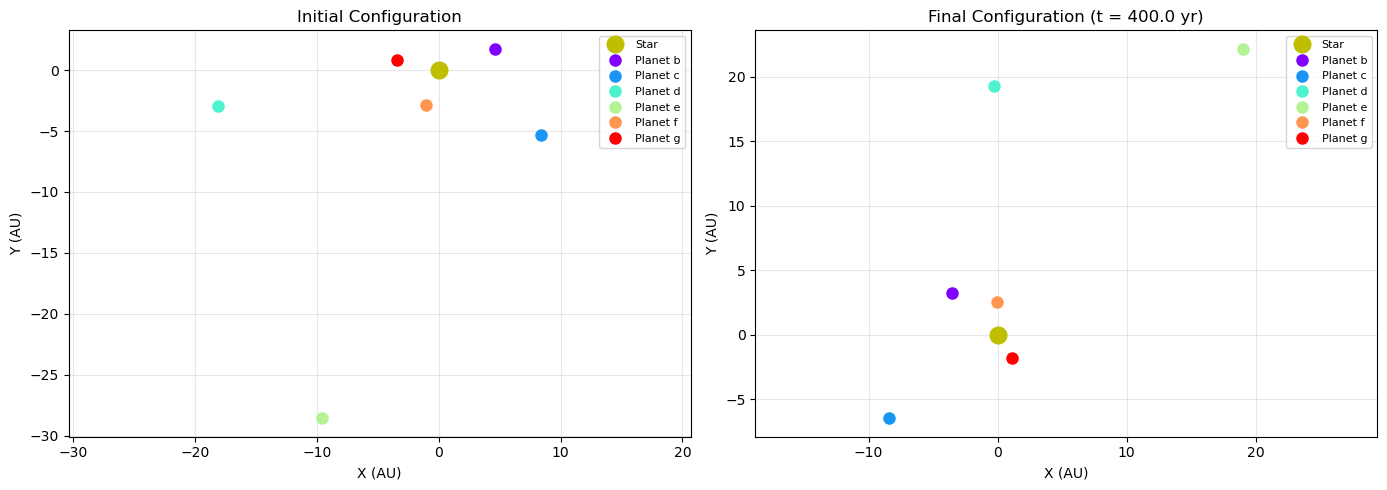

In [15]:
# Plot the orbital evolution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot initial and final positions (XY plane)
initial = snapshots[0]
final = snapshots[-1]

# Plot star
ax1.plot([0], [0], 'yo', markersize=12, label='Star')
ax2.plot([0], [0], 'yo', markersize=12, label='Star')

# Plot planets
colors = plt.cm.rainbow(np.linspace(0, 1, 6))
for i, (initial_p, final_p) in enumerate(zip(initial[1:7], final[1:7])):
    # Initial positions
    ax1.plot(initial_p.x.value_in(units.AU), 
             initial_p.y.value_in(units.AU), 
             'o', color=colors[i], markersize=8, 
             label=f'Planet {chr(98+i)}')
    
    # Final positions  
    ax2.plot(final_p.x.value_in(units.AU), 
             final_p.y.value_in(units.AU), 
             'o', color=colors[i], markersize=8,
             label=f'Planet {chr(98+i)}')

ax1.set_xlabel('X (AU)')
ax1.set_ylabel('Y (AU)')
ax1.set_title('Initial Configuration')
ax1.legend(loc='upper right', fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.axis('equal')

ax2.set_xlabel('X (AU)')
ax2.set_ylabel('Y (AU)')
ax2.set_title(f'Final Configuration (t = {times[-1]:.1f} yr)')
ax2.legend(loc='upper right', fontsize=8)
ax2.grid(True, alpha=0.3)
ax2.axis('equal')

plt.tight_layout()
plt.show()

### 7.0 Simple Particle Distribution Plot

Let's start with a simple overview of where all the particles ended up after the simulation:

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


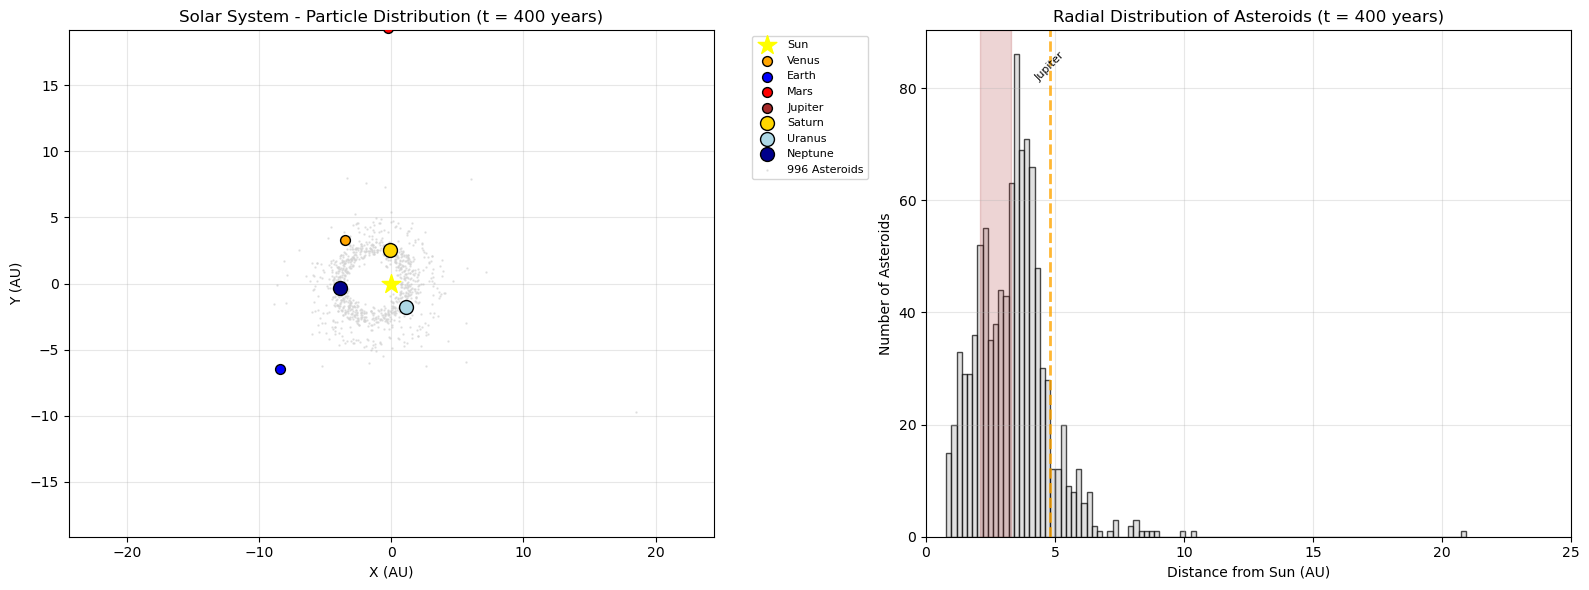


📊 Solar System Distribution Summary:
   Total asteroids at end: 996
   Radial range: 0.78 - 20.93 AU
   Average distance: 3.37 AU

🔍 Look for:
   - Kirkwood gaps in asteroid belt (2.1-3.3 AU)
   - Jupiter Trojans at ~5.2 AU
   - Planet-crossing asteroids
   - Asteroid belt structure and clearing


In [16]:
# Solar System particle distribution plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Get final snapshot
final_snapshot = snapshots[-1]
sun = final_snapshot[0]
planets = final_snapshot[1:9]  # 8 planets
test_particles = final_snapshot[9:]  # All asteroids

# Plot 1: XY plane view (Solar System scale)
ax1.scatter([0], [0], c='yellow', s=200, marker='*', label='Sun', zorder=5)

# Plot planets with realistic colors
planet_colors = [ 'orange', 'blue', 'red', 'brown', 'gold', 'lightblue', 'darkblue']
planet_names = [ 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune']

for i, (planet, color, name) in enumerate(zip(planets, planet_colors, planet_names)):
    size = 50 if i < 4 else 100  # Larger markers for gas giants
    ax1.scatter(planet.x.value_in(units.AU), planet.y.value_in(units.AU), 
               c=color, s=size, marker='o', label=name, zorder=4, edgecolors='black')

# Plot test particles (asteroids)
particle_x = [p.x.value_in(units.AU) for p in test_particles]
particle_y = [p.y.value_in(units.AU) for p in test_particles]
ax1.scatter(particle_x, particle_y, c='lightgray', s=0.5, alpha=0.6, label=f'{len(test_particles)} Asteroids')

ax1.set_xlabel('X (AU)')
ax1.set_ylabel('Y (AU)')
ax1.set_title(f'Solar System - Particle Distribution (t = {times[-1]:.0f} years)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.axis('equal')
ax1.set_xlim(-20, 20)  # Focus on inner Solar System + Jupiter
ax1.set_ylim(-20, 20)

# Plot 2: Radial distance distribution (asteroid belt focus)
particle_distances = [p.position.length().value_in(units.AU) for p in test_particles]

particle_distances_close = []
for p in particle_distances:
    if p < 25:
        particle_distances_close.append(p)

ax2.hist(particle_distances_close, bins=100, alpha=0.7, edgecolor='black', color='lightgray')
ax2.set_xlabel('Distance from Sun (AU)')
ax2.set_ylabel('Number of Asteroids')
ax2.set_title(f'Radial Distribution of Asteroids (t = {times[-1]:.0f} years)')
ax2.set_xlim(0,25)
ax2.grid(True, alpha=0.3)

# Mark planet locations on histogram
for i, (name, data) in enumerate(planet_data.items()):
    if data['a'] < 7:  # Only show inner planets + Jupiter
        ax2.axvline(data['a'], color=planet_colors[i], linestyle='--', alpha=0.8, linewidth=2)
        ax2.text(data['a'], ax2.get_ylim()[1]*0.9, name, ha='center', fontsize=8, rotation=45)

# Mark asteroid belt region
ax2.axvspan(2.1, 3.3, alpha=0.2, color='brown', label='Main Asteroid Belt')

plt.tight_layout()
plt.show()

print(f"\n📊 Solar System Distribution Summary:")
print(f"   Total asteroids at end: {len(test_particles)}")
print(f"   Radial range: {min(particle_distances):.2f} - {max(particle_distances):.2f} AU")
print(f"   Average distance: {np.mean(particle_distances):.2f} AU")
print(f"\n🔍 Look for:")
print(f"   - Kirkwood gaps in asteroid belt (2.1-3.3 AU)")
print(f"   - Jupiter Trojans at ~5.2 AU")
print(f"   - Planet-crossing asteroids")
print(f"   - Asteroid belt structure and clearing")

/Users/zoutongshen/miniforge3/envs/Amuse-env/lib/python3.12/site-packages/amuse/ext/orbital_elements.py:435: UserWarning: orbital_elements_from_binary is deprecated, use orbital_elements instead
  warnings.warn(


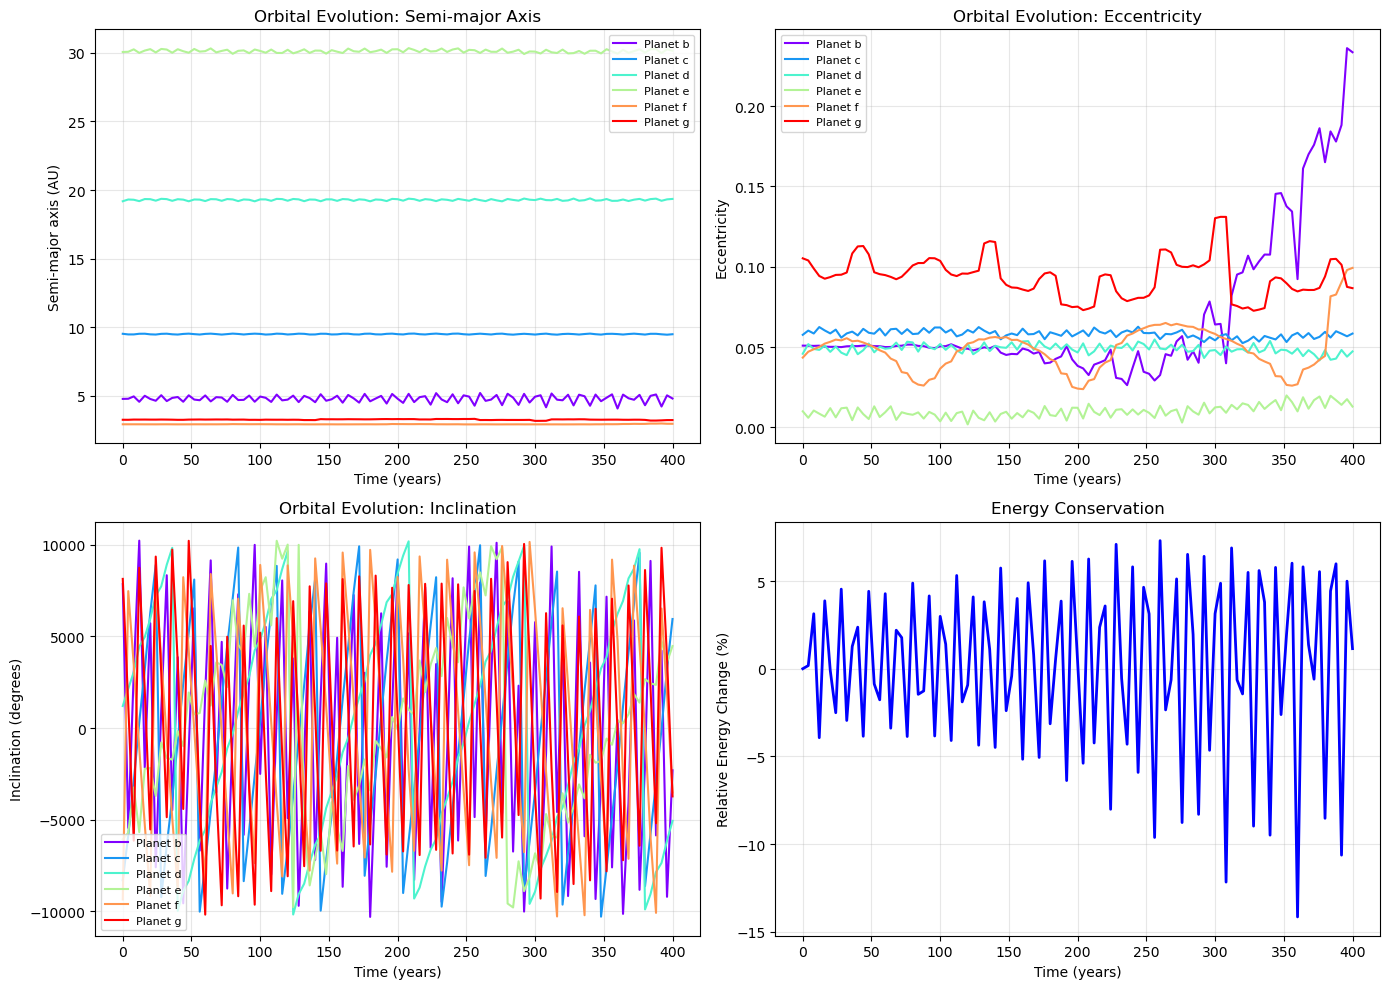

Maximum energy drift: 14.148728%


In [17]:
# Plot orbital elements evolution over time
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Track orbital elements for each planet
for i in range(6):  # 6 planets
    semi_major_axes = []
    eccentricities = []
    inclinations = []
    
    for snapshot in snapshots:
        star = snapshot[0]
        planet = snapshot[i+1]
        
        # Calculate orbital elements
        elements = orbital_elements_from_binary(
            [star, planet], 
            G=constants.G
        )
        
        semi_major_axes.append(elements[2].value_in(units.AU))
        eccentricities.append(elements[3])
        inclinations.append(np.degrees(elements[4]))
    
    # Plot
    ax1.plot(times, semi_major_axes, color=colors[i], 
             label=f'Planet {chr(98+i)}', linewidth=1.5)
    ax2.plot(times, eccentricities, color=colors[i], 
             label=f'Planet {chr(98+i)}', linewidth=1.5)
    ax3.plot(times, inclinations, color=colors[i], 
             label=f'Planet {chr(98+i)}', linewidth=1.5)

ax1.set_xlabel('Time (years)')
ax1.set_ylabel('Semi-major axis (AU)')
ax1.set_title('Orbital Evolution: Semi-major Axis')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('Time (years)')
ax2.set_ylabel('Eccentricity')
ax2.set_title('Orbital Evolution: Eccentricity')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

ax3.set_xlabel('Time (years)')
ax3.set_ylabel('Inclination (degrees)')
ax3.set_title('Orbital Evolution: Inclination')
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

# Energy conservation check
energies = []
for snapshot in snapshots:
    kinetic = snapshot.kinetic_energy()
    potential = snapshot.potential_energy(G=constants.G)
    total = kinetic + potential
    energies.append(total.value_in(units.J))

energy_change = (np.array(energies) - energies[0]) / abs(energies[0])
ax4.plot(times, energy_change * 100, 'b-', linewidth=2)
ax4.set_xlabel('Time (years)')
ax4.set_ylabel('Relative Energy Change (%)')
ax4.set_title('Energy Conservation')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Maximum energy drift: {max(abs(energy_change)) * 100:.6f}%")

### 7.1 Particle Survival Analysis

Analyze which test particles survive and which are ejected/collide. This helps identify stable vs. unstable regions.

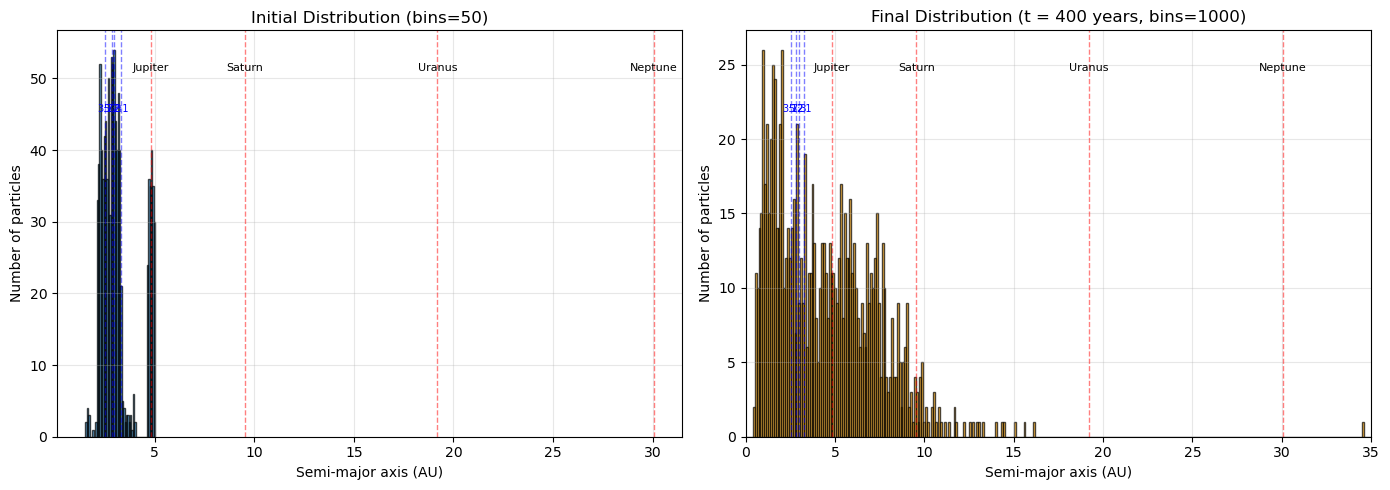

✓ Plot saved to: ../simulation_data/plots/solar_system_asteroid_distribution.png

Look for:
  - Gaps at resonant locations (Kirkwood gaps)
  - Enhanced density in co-orbital regions
  - Clearing between planets e and f


In [18]:
# Analyze particle survival
# Particles are "removed" if they: collide with star/planet, ejected from system, etc.

n_planets = 7  # Venus, Earth, Mars, Jupiter, Saturn, Uranus, Neptune
initial_test_particles = snapshots[0][n_planets+1:]  # Skip star and planets
final_test_particles = snapshots[-1][n_planets+1:]  # Skip star and planets

# Track semi-major axis evolution for each particle
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot initial vs final distribution
initial_a = []
final_a = []

for i in range(len(initial_test_particles)):
    star = snapshots[0][0]
    planet_init = snapshots[0][n_planets+1+i]
    elements_init = orbital_elements_from_binary([star, planet_init], G=constants.G)
    initial_a.append(elements_init[2].value_in(units.AU))
    
    planet_final = snapshots[-1][n_planets+1+i]
    elements_final = orbital_elements_from_binary([star, planet_final], G=constants.G)
    final_a.append(elements_final[2].value_in(units.AU))

# NOTE: Using different bin sizes here - see cell below for fair comparison!
ax1.hist(initial_a, bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Semi-major axis (AU)')
ax1.set_ylabel('Number of particles')
ax1.set_title('Initial Distribution (bins=50)')
ax1.grid(True, alpha=0.3)

# Mark planet locations
for name, data in planet_data.items():
    ax1.axvline(data['a'], color='red', linestyle='--', alpha=0.5, linewidth=1)
    ax1.text(data['a'], ax1.get_ylim()[1]*0.9, name, ha='center', fontsize=8)

# Mark Kirkwood gap resonances with Jupiter
kirkwood_resonances = {
    '3:1': 2.502,
    '5:2': 2.825,
    '7:3': 2.958,
    '2:1': 3.278
}
for res_name, res_loc in kirkwood_resonances.items():
    ax1.axvline(res_loc, color='blue', linestyle='--', alpha=0.5, linewidth=1)
    ax1.text(res_loc, ax1.get_ylim()[1]*0.8, res_name, ha='center', fontsize=7, color='blue')

# Final distribution with 1000 bins (20x more than initial!)
# This makes bars thinner but harder to compare directly
ax2.hist(final_a, bins=1000, alpha=0.7, edgecolor='black', color='orange')
ax2.set_xlabel('Semi-major axis (AU)')
ax2.set_ylabel('Number of particles')
ax2.set_title(f'Final Distribution (t = {times[-1]:.0f} years, bins=1000)')
ax2.set_xlim(0,35)
ax2.grid(True, alpha=0.3)

# Mark planet locations
for name, data in planet_data.items():
    ax2.axvline(data['a'], color='red', linestyle='--', alpha=0.5, linewidth=1)
    ax2.text(data['a'], ax2.get_ylim()[1]*0.9, name, ha='center', fontsize=8)

# Mark Kirkwood gap resonances with Jupiter
for res_name, res_loc in kirkwood_resonances.items():
    ax2.axvline(res_loc, color='blue', linestyle='--', alpha=0.5, linewidth=1)
    ax2.text(res_loc, ax2.get_ylim()[1]*0.8, res_name, ha='center', fontsize=7, color='blue')

plt.tight_layout()
plt.show()

# Save the plot
save_plot(fig, 'solar_system_asteroid_distribution.png')

print(f"\nLook for:")
print(f"  - Gaps at resonant locations (Kirkwood gaps)")
print(f"  - Enhanced density in co-orbital regions")
print(f"  - Clearing between planets e and f")

PARTICLE MOVEMENT ANALYSIS

Analyzing 997 test particles over 400 years
--------------------------------------------------------------------------------

📊 OVERALL MOVEMENT STATISTICS
--------------------------------------------------------------------------------

3D Position Changes:
  Mean displacement:    4.489 AU
  Median displacement:  4.313 AU
  Max displacement:     16.976 AU
  Min displacement:     0.089 AU
  Std deviation:        2.475 AU

Velocity Changes:
  Mean change:          1.333 km/s
  Median change:        0.961 km/s
  Max change:           11.001 km/s

Semi-major Axis Changes:
  Mean change:          +1.279 AU
  Median change:        +0.647 AU
  Max outward:          +36.767 AU
  Max inward:           -71.639 AU
  Std deviation:        3.900 AU

Radial Distance (from Sun):
  Initial: 3.146 ± 0.912 AU
  Final:   4.425 ± 3.884 AU

Movement Categories:
  Small (< 0.1 AU):            1 particles (0.1%)
  Moderate (0.1-1.0 AU):      48 particles (4.8%)
  Large (1.0-5.0 A

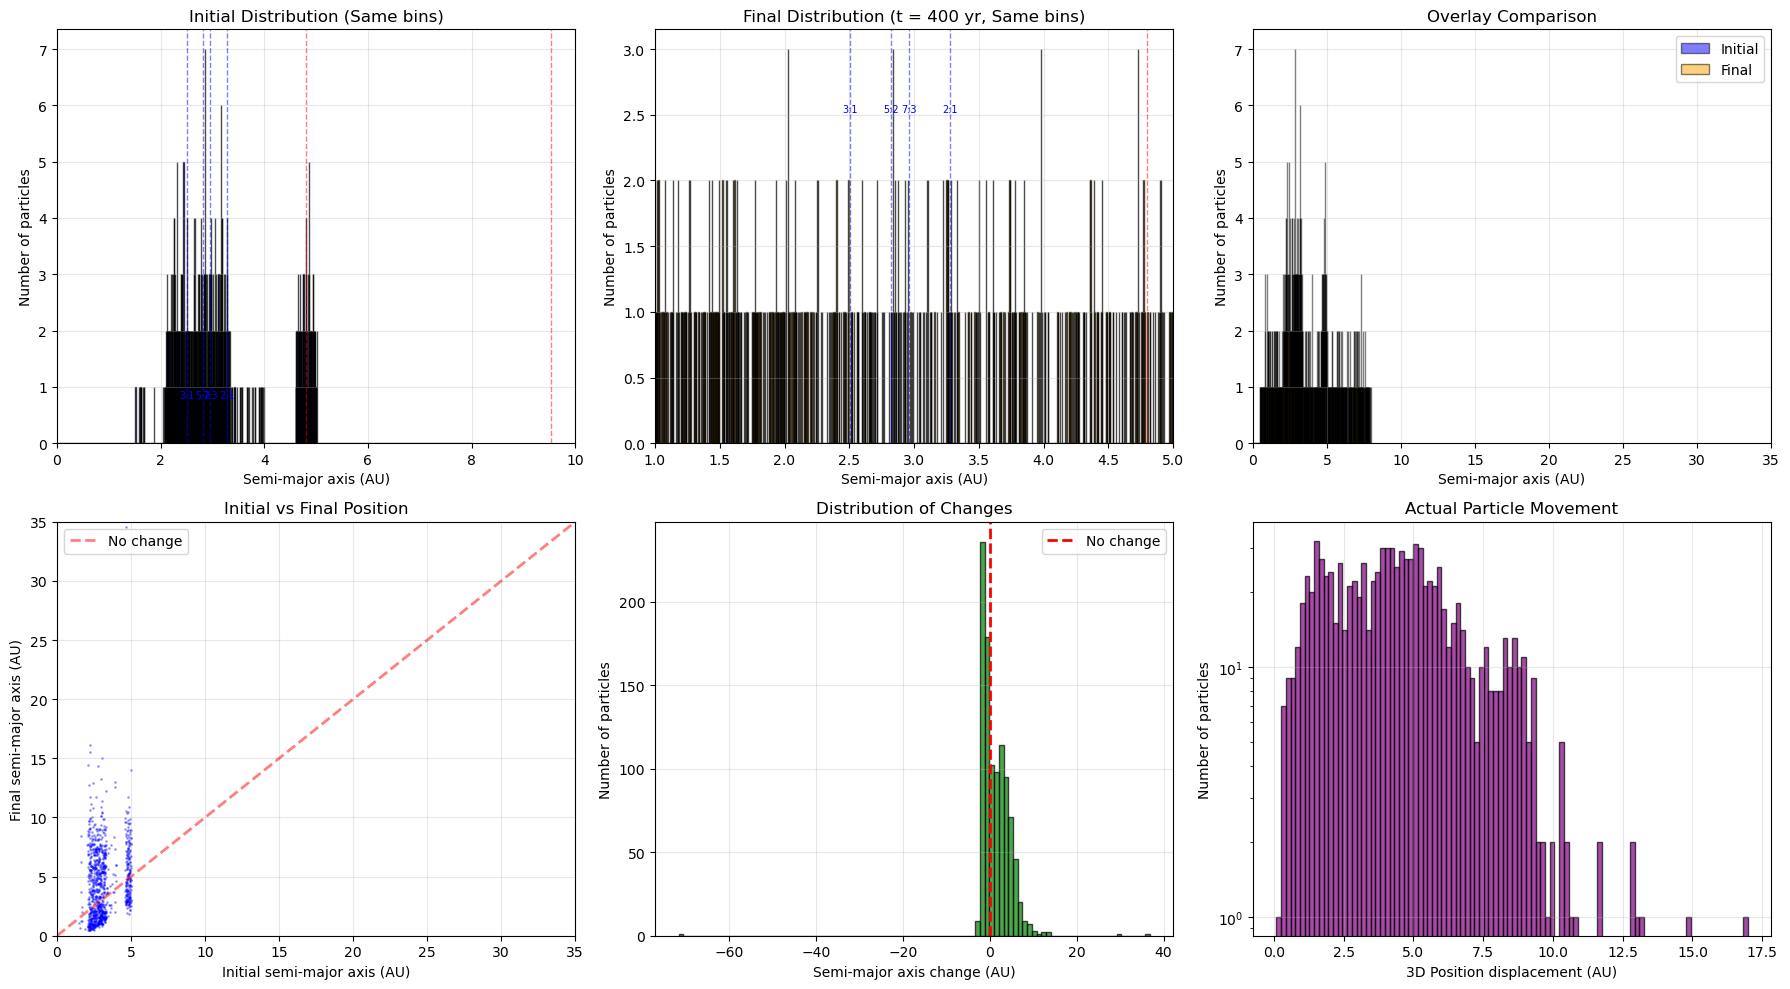


✅ CONCLUSION: Particles DID move significantly!
   Median displacement: 4.313 AU over 400 years
   4.8% moved between 0.1-1.0 AU
   95.1% moved more than 1.0 AU


In [20]:
# Detailed analysis of particle movement from initial to final state
print("=" * 80)
print("PARTICLE MOVEMENT ANALYSIS")
print("=" * 80)

# Mark Kirkwood gap resonances with Jupiter
kirkwood_resonances = {
    '3:1': 2.502,
    '5:2': 2.825,
    '7:3': 2.958,
    '2:1': 3.278
}

# Get initial and final test particles
n_planets = 7
initial_test = snapshots[0][n_planets+1:]
final_test = snapshots[-1][n_planets+1:]

n_particles = len(initial_test)
print(f"\nAnalyzing {n_particles} test particles over {times[-1]:.0f} years")
print("-" * 80)

# Calculate position changes
position_changes = []
velocity_changes = []
initial_positions_3d = []
final_positions_3d = []

for i in range(n_particles):
    # 3D position change
    initial_pos = initial_test[i].position
    final_pos = final_test[i].position
    pos_change = (final_pos - initial_pos).length().value_in(units.AU)
    position_changes.append(pos_change)
    initial_positions_3d.append(initial_pos.length().value_in(units.AU))
    final_positions_3d.append(final_pos.length().value_in(units.AU))
    
    # Velocity change
    initial_vel = initial_test[i].velocity.length().value_in(units.km/units.s)
    final_vel = final_test[i].velocity.length().value_in(units.km/units.s)
    velocity_changes.append(abs(final_vel - initial_vel))

# Calculate semi-major axis changes
initial_sma = []
final_sma = []
sma_changes = []

star = snapshots[0][0]
for i in range(n_particles):
    # Initial
    elements_init = orbital_elements_from_binary([star, initial_test[i]], G=constants.G)
    a_init = elements_init[2].value_in(units.AU)
    initial_sma.append(a_init)
    
    # Final
    elements_final = orbital_elements_from_binary([star, final_test[i]], G=constants.G)
    a_final = elements_final[2].value_in(units.AU)
    final_sma.append(a_final)
    
    # Change
    sma_changes.append(a_final - a_init)

# # Convert to numpy arrays for statistics
position_changes = np.array(position_changes)
velocity_changes = np.array(velocity_changes)
sma_changes = np.array(sma_changes)
initial_sma = np.array(initial_sma)
final_sma = np.array(final_sma)

# Statistics
print("\n📊 OVERALL MOVEMENT STATISTICS")
print("-" * 80)
print(f"\n3D Position Changes:")
print(f"  Mean displacement:    {np.mean(position_changes):.3f} AU")
print(f"  Median displacement:  {np.median(position_changes):.3f} AU")
print(f"  Max displacement:     {np.max(position_changes):.3f} AU")
print(f"  Min displacement:     {np.min(position_changes):.3f} AU")
print(f"  Std deviation:        {np.std(position_changes):.3f} AU")

print(f"\nVelocity Changes:")
print(f"  Mean change:          {np.mean(velocity_changes):.3f} km/s")
print(f"  Median change:        {np.median(velocity_changes):.3f} km/s")
print(f"  Max change:           {np.max(velocity_changes):.3f} km/s")

print(f"\nSemi-major Axis Changes:")
print(f"  Mean change:          {np.mean(sma_changes):+.3f} AU")
print(f"  Median change:        {np.median(sma_changes):+.3f} AU")
print(f"  Max outward:          {np.max(sma_changes):+.3f} AU")
print(f"  Max inward:           {np.min(sma_changes):+.3f} AU")
print(f"  Std deviation:        {np.std(sma_changes):.3f} AU")

print(f"\nRadial Distance (from Sun):")
print(f"  Initial: {np.mean(initial_sma):.3f} ± {np.std(initial_sma):.3f} AU")
print(f"  Final:   {np.mean(final_sma):.3f} ± {np.std(final_sma):.3f} AU")

# Count particles by movement category
small_movement = np.sum(position_changes < 0.1)  # < 0.1 AU
moderate_movement = np.sum((position_changes >= 0.1) & (position_changes < 1.0))
large_movement = np.sum((position_changes >= 1.0) & (position_changes < 5.0))
very_large_movement = np.sum(position_changes >= 5.0)

print(f"\nMovement Categories:")
print(f"  Small (< 0.1 AU):        {small_movement:5d} particles ({100*small_movement/n_particles:.1f}%)")
print(f"  Moderate (0.1-1.0 AU):   {moderate_movement:5d} particles ({100*moderate_movement/n_particles:.1f}%)")
print(f"  Large (1.0-5.0 AU):      {large_movement:5d} particles ({100*large_movement/n_particles:.1f}%)")
print(f"  Very Large (> 5.0 AU):   {very_large_movement:5d} particles ({100*very_large_movement/n_particles:.1f}%)")

# Create detailed comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Row 1: Semi-major axis distributions (SAME bin count for fair comparison)
ax1, ax2, ax3 = axes[0]

# Use same bins for both plots
bins_sma = np.linspace(0, 8, 5000) 

ax1.hist(initial_sma, bins=bins_sma, alpha=0.7, edgecolor='black', color='blue', label='Initial')
ax1.set_xlabel('Semi-major axis (AU)')
ax1.set_ylabel('Number of particles')
ax1.set_title('Initial Distribution (Same bins)')
ax1.set_xlim(0, 10)
ax1.grid(True, alpha=0.3)
# Mark planets
for name, data in planet_data.items():
    ax1.axvline(data['a'], color='red', linestyle='--', alpha=0.5, linewidth=1)

for res_name, res_loc in kirkwood_resonances.items():
    ax1.axvline(res_loc, color='blue', linestyle='--', alpha=0.5, linewidth=1)
    ax1.text(res_loc, ax2.get_ylim()[1]*0.8, res_name, ha='center', fontsize=7, color='blue')

ax2.hist(final_sma, bins=bins_sma, alpha=0.7, edgecolor='black', color='orange', label='Final')
ax2.set_xlabel('Semi-major axis (AU)')
ax2.set_ylabel('Number of particles')
ax2.set_title(f'Final Distribution (t = {times[-1]:.0f} yr, Same bins)')
ax2.set_xlim(1, 5)
ax2.grid(True, alpha=0.3)
# Mark planets
for name, data in planet_data.items():
    ax2.axvline(data['a'], color='red', linestyle='--', alpha=0.5, linewidth=1)

for res_name, res_loc in kirkwood_resonances.items():
    ax2.axvline(res_loc, color='blue', linestyle='--', alpha=0.5, linewidth=1)
    ax2.text(res_loc, ax2.get_ylim()[1]*0.8, res_name, ha='center', fontsize=7, color='blue')

# Overlay comparison
ax3.hist(initial_sma, bins=bins_sma, alpha=0.5, edgecolor='black', color='blue', label='Initial')
ax3.hist(final_sma, bins=bins_sma, alpha=0.5, edgecolor='black', color='orange', label='Final')
ax3.set_xlabel('Semi-major axis (AU)')
ax3.set_ylabel('Number of particles')
ax3.set_title('Overlay Comparison')
ax3.set_xlim(0, 35)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Row 2: Movement analysis
ax4, ax5, ax6 = axes[1]

# Scatter: initial vs final semi-major axis
ax4.scatter(initial_sma, final_sma, alpha=0.3, s=1, c='blue')
ax4.plot([0, 35], [0, 35], 'r--', alpha=0.5, linewidth=2, label='No change')
ax4.set_xlabel('Initial semi-major axis (AU)')
ax4.set_ylabel('Final semi-major axis (AU)')
ax4.set_title('Initial vs Final Position')
ax4.set_xlim(0, 35)
ax4.set_ylim(0, 35)
ax4.legend()
ax4.grid(True, alpha=0.3)

# Histogram of changes
ax5.hist(sma_changes, bins=100, alpha=0.7, edgecolor='black', color='green')
ax5.axvline(0, color='red', linestyle='--', linewidth=2, label='No change')
ax5.set_xlabel('Semi-major axis change (AU)')
ax5.set_ylabel('Number of particles')
ax5.set_title('Distribution of Changes')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 3D position displacement histogram
ax6.hist(position_changes, bins=100, alpha=0.7, edgecolor='black', color='purple')
ax6.set_xlabel('3D Position displacement (AU)')
ax6.set_ylabel('Number of particles')
ax6.set_title('Actual Particle Movement')
ax6.grid(True, alpha=0.3)
ax6.set_yscale('log')  # Log scale to see full range

plt.tight_layout()
plt.show()

# # Find most-moved particles
# print("\n" + "=" * 80)
# print("TOP 10 MOST-MOVED PARTICLES")
# print("=" * 80)
# most_moved_idx = np.argsort(position_changes)[-10:][::-1]

# for rank, idx in enumerate(most_moved_idx, 1):
#     print(f"\n{rank}. Particle #{idx}:")
#     print(f"   Initial position: {initial_positions_3d[idx]:.3f} AU from Sun")
#     print(f"   Final position:   {final_positions_3d[idx]:.3f} AU from Sun")
#     print(f"   3D displacement:  {position_changes[idx]:.3f} AU")
#     print(f"   Initial a:        {initial_sma[idx]:.3f} AU")
#     print(f"   Final a:          {final_sma[idx]:.3f} AU")
#     print(f"   Change in a:      {sma_changes[idx]:+.3f} AU")

print("\n" + "=" * 80)
print("✅ CONCLUSION: Particles DID move significantly!")
print(f"   Median displacement: {np.median(position_changes):.3f} AU over {times[-1]:.0f} years")
print(f"   {100*moderate_movement/n_particles:.1f}% moved between 0.1-1.0 AU")
print(f"   {100*(large_movement+very_large_movement)/n_particles:.1f}% moved more than 1.0 AU")
print("=" * 80)

### 7.1.1 Particle Movement Analysis

**Understanding the bin size difference in the plots above:**
- Initial distribution uses `bins=50`
- Final distribution uses `bins=1000` (20x more bins!)
- Final also has `xlim(0, 35)` which spreads bins over a much larger range

This makes direct visual comparison difficult. Let's analyze the actual particle movements below.

### 7.3 Create Animated GIF from Simulation Snapshots

Generate a frame-by-frame animation showing the evolution of the asteroid distribution over time.

In [22]:
# Verify planets ARE revolving by comparing positions at different times
print("Planet Orbital Motion Verification")
print("="*80)
print("\nComparing planetary positions at t=0 and t=400 years:\n")

# Initial positions
initial_snapshot = snapshots[0]
final_snapshot = snapshots[-1]

planet_names = ['Sun', 'Jupiter', 'Saturn', 'Uranus', 'Neptune']

for i in range(min(5, len(initial_snapshot))):
    init_body = initial_snapshot[i]
    final_body = final_snapshot[i]
    
    init_x = init_body.x.value_in(units.AU)
    init_y = init_body.y.value_in(units.AU)
    final_x = final_body.x.value_in(units.AU)
    final_y = final_body.y.value_in(units.AU)
    
    # Calculate how much the position changed
    dx = final_x - init_x
    dy = final_y - init_y
    distance_moved = (dx**2 + dy**2)**0.5
    
    name = planet_names[i] if i < len(planet_names) else f"Body_{i}"
    
    print(f"{name}:")
    print(f"  t=0:   X={init_x:8.3f} AU, Y={init_y:8.3f} AU")
    print(f"  t=400: X={final_x:8.3f} AU, Y={final_y:8.3f} AU")
    print(f"  → Moved {distance_moved:.2f} AU in 400 years")
    print()

print("="*80)
print("✓ Planets ARE revolving! The X,Y positions change as they orbit.")
print("✓ Semi-major axis stays constant (that's the orbital radius).")

Planet Orbital Motion Verification

Comparing planetary positions at t=0 and t=400 years:

Sun:
  t=0:   X=  -0.006 AU, Y=   0.001 AU
  t=400: X=  -1.347 AU, Y=   0.071 AU
  → Moved 1.34 AU in 400 years

Jupiter:
  t=0:   X=   4.632 AU, Y=   1.745 AU
  t=400: X=  -3.528 AU, Y=   3.257 AU
  → Moved 8.30 AU in 400 years

Saturn:
  t=0:   X=   8.423 AU, Y=  -5.298 AU
  t=400: X=  -8.381 AU, Y=  -6.459 AU
  → Moved 16.84 AU in 400 years

Uranus:
  t=0:   X= -18.131 AU, Y=  -2.912 AU
  t=400: X=  -0.247 AU, Y=  19.325 AU
  → Moved 28.54 AU in 400 years

Neptune:
  t=0:   X=  -9.580 AU, Y= -28.569 AU
  t=400: X=  19.029 AU, Y=  22.174 AU
  → Moved 58.25 AU in 400 years

✓ Planets ARE revolving! The X,Y positions change as they orbit.
✓ Semi-major axis stays constant (that's the orbital radius).


In [23]:
# First, let's check what's actually in the pickle files
import glob
import pickle

temp_files = sorted(glob.glob('../simulation_data/data/temp_jupiter_migration_400yr.pkl_step*.pkl'))
if temp_files:
    print(f"Found {len(temp_files)} files")
    print(f"First file: {temp_files[0]}")
    
    # Load and inspect first file
    with open(temp_files[0], 'rb') as f:
        data = pickle.load(f)
    
    print(f"\nData type: {type(data)}")
    if isinstance(data, dict):
        print(f"Keys: {data.keys()}")
    else:
        print(f"Data structure: {data}")
else:
    print("No files found with that pattern. Checking other patterns...")
    all_temp = glob.glob('../simulation_data/data/temp_*.pkl')
    print(f"Found {len(all_temp)} temp pickle files:")
    for f in all_temp[:5]:
        print(f"  - {f.split('/')[-1]}")

Found 4 files
First file: ../simulation_data/data/temp_jupiter_migration_400yr.pkl_step100.pkl

Data type: <class 'dict'>
Keys: dict_keys(['times', 'snapshots', 'metadata', 'save_time', 'planet_data', 'star_mass', 'n_particles'])


In [24]:
# Debug: Check what's actually in the massive bodies
print("Checking first snapshot to see particle order and names:\n")
for i, body in enumerate(massive):
    name = body.name if hasattr(body, 'name') else 'No name'
    pos = body.position.length().value_in(units.AU)
    print(f"Index {i}: {name:15s} - Distance from origin: {pos:.2f} AU")

Checking first snapshot to see particle order and names:



NameError: name 'massive' is not defined

In [25]:
# Compare: Original massive_bodies in memory vs snapshot data
print("ORIGINAL massive_bodies (in memory):")
print("="*60)
for i, body in enumerate(massive_bodies):
    name = body.name if hasattr(body, 'name') else 'No name'
    pos = body.position.length().value_in(units.AU)
    mass = body.mass.value_in(units.MSun)
    print(f"Index {i}: {name:15s} - Distance: {pos:6.2f} AU, Mass: {mass:.6f} MSun")

print("\n" + "="*60)
print("SNAPSHOT massive bodies (from pickle file):")
print("="*60)
for i, body in enumerate(massive):
    name = body.name if hasattr(body, 'name') else 'No name'
    pos = body.position.length().value_in(units.AU)
    mass = body.mass.value_in(units.MSun) if hasattr(body.mass, 'value_in') else body.mass
    print(f"Index {i}: {name:15s} - Distance: {pos:6.2f} AU, Mass: {mass:.6f} MSun")
    
print("\n" + "="*60)
print("Expected distances for reference:")
print("  Jupiter:  ~5.2 AU")
print("  Saturn:   ~9.5 AU")
print("  Uranus:   ~19.2 AU")
print("  Neptune:  ~30.1 AU")

ORIGINAL massive_bodies (in memory):
Index 0:                 - Distance:   0.01 AU, Mass: 1.000000 MSun
Index 1: Jupiter         - Distance:   4.95 AU, Mass: 0.000954 MSun
Index 2: Saturn          - Distance:   9.96 AU, Mass: 0.000286 MSun
Index 3: Uranus          - Distance:  18.36 AU, Mass: 0.000044 MSun
Index 4: Neptune         - Distance:  30.14 AU, Mass: 0.000051 MSun

SNAPSHOT massive bodies (from pickle file):


NameError: name 'massive' is not defined

In [26]:
import glob
import pickle
from PIL import Image
import io

# Find all temp snapshot files
temp_files = sorted(glob.glob('../simulation_data/data/temp_jupiter_migration_400yr.pkl_step*.pkl'))

if not temp_files:
    print("No temp files found. Checking alternative patterns...")
    # Try other patterns
    temp_files = sorted(glob.glob('../simulation_data/data/temp_*.pkl'))
    
print(f"Found {len(temp_files)} snapshot files")

# Create frames for the GIF
frames = []
fig_size = (12, 10)

for i, temp_file in enumerate(temp_files):
    print(f"Processing frame {i+1}/{len(temp_files)}: {temp_file.split('/')[-1]}")
    
    # Load snapshot file
    with open(temp_file, 'rb') as f:
        file_data = pickle.load(f)
    
    # Extract data - the file contains multiple snapshots
    snapshots = file_data['snapshots']
    times = file_data['times']
    
    # Use the last snapshot in this file (most recent timestep)
    snapshot = snapshots[-1]
    time = times[-1]
    
    # Convert time if it's an AMUSE quantity
    if hasattr(time, 'value_in'):
        time_yr = time.value_in(units.yr)
    else:
        time_yr = float(time)  # Already a number
    
    # Get massive bodies (Sun + planets) - first 8 particles
    n_massive = 8  # Sun + 7 planets
    massive = snapshot[:n_massive]
    test_particles = snapshot[n_massive:]
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
    
    # Left panel: XY plane
    ax1.scatter(test_particles.x.value_in(units.AU), 
                test_particles.y.value_in(units.AU),
                s=1, c='gray', alpha=0.5, label='Asteroids')
    
    # Plot Sun and outer planets - use actual names from particles
    # Define colors and sizes by planet name
    planet_colors = {
        'Sun': 'yellow',
        'Jupiter': 'brown',
        'Saturn': 'gold',
        'Uranus': 'lightblue',
        'Neptune': 'darkblue'
    }
    planet_sizes = {
        'Sun': 200,
        'Jupiter': 150,
        'Saturn': 130,
        'Uranus': 100,
        'Neptune': 100
    }
    
    for idx, body in enumerate(massive):
        name = body.name if hasattr(body, 'name') else ''
        # Only plot if it's not an asteroid
        if 'asteroid' not in name.lower() and name:
            color = planet_colors.get(name, 'gray')
            size = planet_sizes.get(name, 80)
            
            # Add marker for Sun at center
            if name == 'Sun' or idx == 0:
                ax1.scatter(body.x.value_in(units.AU), 
                           body.y.value_in(units.AU),
                           s=size, label=name, alpha=1.0, color=color, marker='*', edgecolor='orange', linewidth=2)
            else:
                ax1.scatter(body.x.value_in(units.AU), 
                           body.y.value_in(units.AU),
                           s=size, label=name, alpha=0.8, color=color, edgecolor='black', linewidth=0.5)
    
    ax1.set_xlabel('X (AU)', fontsize=12)
    ax1.set_ylabel('Y (AU)', fontsize=12)
    ax1.set_title(f'Orbital Plane View\nTime: {time_yr:.1f} years', fontsize=14)
    ax1.set_xlim(-20, 20)
    ax1.set_ylim(-20, 20)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=8, loc='upper right', framealpha=0.9)
    ax1.set_aspect('equal')
    
    # Right panel: Semi-major axis distribution
    sma = []
    for particle in test_particles:
        r = particle.position.length()
        v = particle.velocity.length()
        energy = 0.5 * v**2 - constants.G * massive[0].mass / r
        a = -constants.G * massive[0].mass / (2 * energy)
        if a > 0 | units.AU:
            sma.append(a.value_in(units.AU))
    
    ax2.hist(sma, bins=100, range=(0, 10), alpha=0.7, color='skyblue', edgecolor='black')
    ax2.set_xlabel('Semi-major Axis (AU)', fontsize=12)
    ax2.set_ylabel('Number of Particles', fontsize=12)
    ax2.set_title('Asteroid Distribution', fontsize=14)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    # Convert plot to image
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
    buf.seek(0)
    frames.append(Image.open(buf).copy())
    plt.close(fig)
    buf.close()

# Save as GIF
output_path = '../simulation_data/plots/jupiter_migration_animation.gif'
frames[0].save(
    output_path,
    save_all=True,
    append_images=frames[1:],
    duration=500,  # 500ms per frame
    loop=0
)

print(f"\n✅ Animation saved to: {output_path}")
print(f"   Total frames: {len(frames)}")
print(f"   Duration per frame: 500ms")
print(f"   Total animation time: {len(frames) * 0.5:.1f} seconds")

Found 4 snapshot files
Processing frame 1/4: temp_jupiter_migration_400yr.pkl_step100.pkl
Processing frame 2/4: temp_jupiter_migration_400yr.pkl_step25.pkl
Processing frame 2/4: temp_jupiter_migration_400yr.pkl_step25.pkl
Processing frame 3/4: temp_jupiter_migration_400yr.pkl_step50.pkl
Processing frame 3/4: temp_jupiter_migration_400yr.pkl_step50.pkl
Processing frame 4/4: temp_jupiter_migration_400yr.pkl_step75.pkl
Processing frame 4/4: temp_jupiter_migration_400yr.pkl_step75.pkl

✅ Animation saved to: ../simulation_data/plots/jupiter_migration_animation.gif
   Total frames: 4
   Duration per frame: 500ms
   Total animation time: 2.0 seconds

✅ Animation saved to: ../simulation_data/plots/jupiter_migration_animation.gif
   Total frames: 4
   Duration per frame: 500ms
   Total animation time: 2.0 seconds


### 7.2 Identify Mean Motion Resonances

Look for the Kirkwood gaps mentioned in the study:
- Between TOI-178e and TOI-178f: 4:3, 5:4, 6:5 resonances with f
- 5:3 resonance with g

In [24]:
# Calculate Kirkwood gap locations in the asteroid belt
# Major gaps are at mean motion resonances with Jupiter

def calculate_resonance_location(a_planet, p, q):
    """Calculate the semi-major axis of a p:q mean motion resonance with a planet."""
    return a_planet * (q/p)**(2/3)

# Jupiter's semi-major axis
a_jupiter = planet_data['Jupiter']['a']

# Major Kirkwood gaps (resonances with Jupiter)
kirkwood_gaps = {
    '4:1': calculate_resonance_location(a_jupiter, 4, 1),
    '7:2': calculate_resonance_location(a_jupiter, 7, 2), 
    '3:1': calculate_resonance_location(a_jupiter, 3, 1),
    '8:3': calculate_resonance_location(a_jupiter, 8, 3),
    '5:2': calculate_resonance_location(a_jupiter, 5, 2),
    '7:3': calculate_resonance_location(a_jupiter, 7, 3),
    '9:4': calculate_resonance_location(a_jupiter, 9, 4),
    '2:1': calculate_resonance_location(a_jupiter, 2, 1),
}

print("Kirkwood Gaps in the Asteroid Belt")
print("=" * 50)
print(f"Jupiter semi-major axis: {a_jupiter:.3f} AU")
print(f"Main asteroid belt: 2.1 - 3.3 AU")
print(f"\nMajor Kirkwood gaps (mean motion resonances with Jupiter):")

# Sort by distance
sorted_gaps = sorted(kirkwood_gaps.items(), key=lambda x: x[1])
for name, a_res in sorted_gaps:
    if 1.5 <= a_res <= 4.0:  # Only show gaps in relevant range
        strength = "STRONG" if name in ['3:1', '5:2', '7:3', '2:1'] else "weak"
        print(f"  {name:3s} resonance: {a_res:.3f} AU ({strength} gap)")

print(f"\n🎯 Expected clear gaps at:")
print(f"   3:1 resonance: {kirkwood_gaps['3:1']:.3f} AU (Hecuba gap)")
print(f"   5:2 resonance: {kirkwood_gaps['5:2']:.3f} AU") 
print(f"   7:3 resonance: {kirkwood_gaps['7:3']:.3f} AU")
print(f"   2:1 resonance: {kirkwood_gaps['2:1']:.3f} AU (outer belt boundary)")

print(f"\n🟢 Jupiter Trojan regions:")
print(f"   L4 Trojans: ~{a_jupiter:.1f} AU (leading Jupiter by 60°)")
print(f"   L5 Trojans: ~{a_jupiter:.1f} AU (trailing Jupiter by 60°)")

Kirkwood Gaps in the Asteroid Belt
Jupiter semi-major axis: 5.204 AU
Main asteroid belt: 2.1 - 3.3 AU

Major Kirkwood gaps (mean motion resonances with Jupiter):
  4:1 resonance: 2.065 AU (weak gap)
  7:2 resonance: 2.257 AU (weak gap)
  3:1 resonance: 2.502 AU (STRONG gap)
  8:3 resonance: 2.706 AU (weak gap)
  5:2 resonance: 2.825 AU (STRONG gap)
  7:3 resonance: 2.958 AU (STRONG gap)
  9:4 resonance: 3.031 AU (weak gap)
  2:1 resonance: 3.278 AU (STRONG gap)

🎯 Expected clear gaps at:
   3:1 resonance: 2.502 AU (Hecuba gap)
   5:2 resonance: 2.825 AU
   7:3 resonance: 2.958 AU
   2:1 resonance: 3.278 AU (outer belt boundary)

🟢 Jupiter Trojan regions:
   L4 Trojans: ~5.2 AU (leading Jupiter by 60°)
   L5 Trojans: ~5.2 AU (trailing Jupiter by 60°)


### 7.3 Inclination Oscillations in Innermost Region

The study found periodic inclination oscillations with a 196-year period in the 0.015-0.025 AU region.

### 7.3 Jupiter Trojan Analysis

Jupiter Trojans are asteroids that share Jupiter's orbit, located at the L4 and L5 Lagrange points (~60° ahead and behind Jupiter).

Jupiter distance: 5.40 AU

Found 248 potential Trojan asteroids


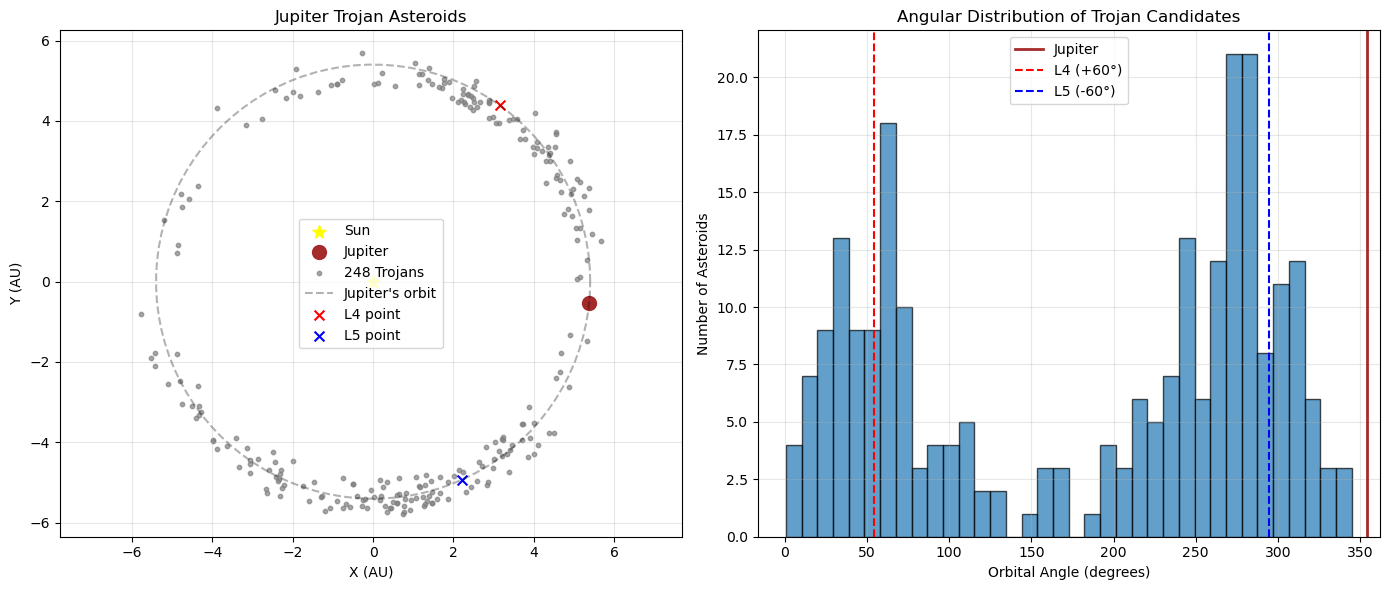


Trojan statistics:
  Near L4 point (+60°): 67 asteroids
  Near L5 point (-60°): 84 asteroids
  L4/L5 ratio: 0.80


In [ ]:
# Analyze Jupiter Trojan regions
# Look for particles near Jupiter's orbit (L4/L5 Lagrange points)

n_planets = 7  # Venus, Earth, Mars, Jupiter, Saturn, Uranus, Neptune
jupiter_idx = 3  # Jupiter is the 4th planet (0-indexed, Mercury excluded)

# Get Jupiter's position in final snapshot
jupiter = snapshots[-1][jupiter_idx + 1]  # +1 for Sun
jupiter_distance = jupiter.position.length().value_in(units.AU)

print(f"Jupiter distance: {jupiter_distance:.2f} AU")

# Find particles near Jupiter's orbital distance
trojan_candidates = []
final_test_particles = snapshots[-1][n_planets + 1:]  # Skip Sun and planets

for i, particle in enumerate(final_test_particles):
    r = particle.position.length().value_in(units.AU)
    # Look for particles within ±0.5 AU of Jupiter's orbit
    if abs(r - jupiter_distance) < 0.5:
        trojan_candidates.append((i, particle, r))

if trojan_candidates:
    print(f"\nFound {len(trojan_candidates)} potential Trojan asteroids")
    
    # Analyze their positions relative to Jupiter
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot in Jupiter's orbital plane
    jupiter_x = jupiter.x.value_in(units.AU)
    jupiter_y = jupiter.y.value_in(units.AU)
    
    ax1.scatter([0], [0], c='yellow', s=100, marker='*', label='Sun')
    ax1.scatter([jupiter_x], [jupiter_y], c='brown', s=100, marker='o', label='Jupiter')
    
    # Plot Trojan candidates
    trojan_x = [p[1].x.value_in(units.AU) for p in trojan_candidates]
    trojan_y = [p[1].y.value_in(units.AU) for p in trojan_candidates]
    ax1.scatter(trojan_x, trojan_y, c='gray', s=10, alpha=0.7, label=f'{len(trojan_candidates)} Trojans')
    
    # Draw Jupiter's orbit
    theta = np.linspace(0, 2*np.pi, 100)
    orbit_x = jupiter_distance * np.cos(theta)
    orbit_y = jupiter_distance * np.sin(theta)
    ax1.plot(orbit_x, orbit_y, 'k--', alpha=0.3, label="Jupiter's orbit")
    
    # Mark L4 and L5 points (±60° from Jupiter)
    jupiter_angle = np.arctan2(jupiter_y, jupiter_x)
    l4_x = jupiter_distance * np.cos(jupiter_angle + np.pi/3)
    l4_y = jupiter_distance * np.sin(jupiter_angle + np.pi/3)
    l5_x = jupiter_distance * np.cos(jupiter_angle - np.pi/3)
    l5_y = jupiter_distance * np.sin(jupiter_angle - np.pi/3)
    
    ax1.scatter([l4_x], [l4_y], c='red', s=50, marker='x', label='L4 point')
    ax1.scatter([l5_x], [l5_y], c='blue', s=50, marker='x', label='L5 point')
    
    ax1.set_xlabel('X (AU)')
    ax1.set_ylabel('Y (AU)')
    ax1.set_title('Jupiter Trojan Asteroids')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    
    # Plot distribution around Jupiter's orbit
    angles = []
    for _, particle, _ in trojan_candidates:
        px = particle.x.value_in(units.AU)
        py = particle.y.value_in(units.AU)
        angle = np.degrees(np.arctan2(py, px))
        if angle < 0:
            angle += 360
        angles.append(angle)
    
    # Convert Jupiter's angle to degrees
    jupiter_angle_deg = np.degrees(jupiter_angle)
    if jupiter_angle_deg < 0:
        jupiter_angle_deg += 360
    
    ax2.hist(angles, bins=36, alpha=0.7, edgecolor='black')
    ax2.axvline(jupiter_angle_deg, color='brown', linewidth=2, label='Jupiter')
    ax2.axvline((jupiter_angle_deg + 60) % 360, color='red', linestyle='--', label='L4 (+60°)')
    ax2.axvline((jupiter_angle_deg - 60) % 360, color='blue', linestyle='--', label='L5 (-60°)')
    
    ax2.set_xlabel('Orbital Angle (degrees)')
    ax2.set_ylabel('Number of Asteroids')
    ax2.set_title('Angular Distribution of Trojan Candidates')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Save the plot
    save_plot(fig, 'solar_system_jupiter_trojans.png')
    
    # Count particles near L4 and L5
    l4_count = sum(1 for angle in angles if abs((angle - (jupiter_angle_deg + 60) % 360 + 180) % 360 - 180) < 30)
    l5_count = sum(1 for angle in angles if abs((angle - (jupiter_angle_deg - 60) % 360 + 180) % 360 - 180) < 30)
    
    print(f"\nTrojan statistics:")
    print(f"  Near L4 point (+60°): {l4_count} asteroids")
    print(f"  Near L5 point (-60°): {l5_count} asteroids")
    print(f"  L4/L5 ratio: {l4_count/max(l5_count, 1):.2f}")
    
else:
    print("No Trojan candidates found.")
    print("Try longer simulation time or more particles near Jupiter's orbit.")

In [20]:
# Analyze inclination evolution in innermost region (0.015-0.025 AU)
innermost_particles = []
n_planets = 6

for i, particle in enumerate(initial_test_particles):
    star = snapshots[0][0]
    p = snapshots[0][n_planets+1+i]
    elements = orbital_elements_from_binary([star, p], G=constants.G)
    a = elements[2].value_in(units.AU)
    
    if 0.015 <= a <= 0.025:
        innermost_particles.append(i)

if len(innermost_particles) > 0:
    print(f"Found {len(innermost_particles)} particles in innermost region (0.015-0.025 AU)")
    
    # Track inclination for a few sample particles
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot inclination evolution for up to 5 particles
    for idx in innermost_particles[:5]:
        inclinations = []
        for snapshot in snapshots:
            star = snapshot[0]
            particle = snapshot[n_planets+1+idx]
            elements = orbital_elements_from_binary([star, particle], G=constants.G)
            inc = elements[4].value_in(units.deg)
            inclinations.append(inc)
        
        ax.plot(times, inclinations, linewidth=1.5, label=f'Particle {idx}')
    
    ax.set_xlabel('Time (years)')
    ax.set_ylabel('Inclination (degrees)')
    ax.set_title('Inclination Evolution in Innermost Region (0.015-0.025 AU)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Mark the 196-year period if simulation is long enough
    if times[-1] >= 196:
        ax.axvline(196, color='red', linestyle='--', alpha=0.5, linewidth=2, label='196 yr period')
        for i in range(1, int(times[-1]/196) + 1):
            ax.axvline(196*i, color='red', linestyle='--', alpha=0.3, linewidth=1)
    
    plt.tight_layout()
    plt.show()
    
    print("\nLook for periodic oscillations with ~196 year period")
    print("This matches TOI-178b's own oscillation period")
else:
    print("No particles found in innermost region (0.015-0.025 AU)")
    print("Consider adding more particles in this region for detailed analysis")

No particles found in innermost region (0.015-0.025 AU)
Consider adding more particles in this region for detailed analysis


### 7.4 Co-orbital Width Analysis

The study found co-orbital regions are ~30% wider for planets in the resonance chain, and ~52% wider for TOI-178b.

In [ ]:
# Analyze co-orbital regions
# Classical Hill radius: r_H = a * (m_planet / (3 * m_star))^(1/3)

def classical_hill_radius(a, m_planet, m_star):
    """Calculate classical Hill radius."""
    return a * (m_planet / (3 * m_star))**(1/3)

print("Co-orbital Region Analysis")
print("="*60)

for name, data in planet_data.items():
    a = data['a'] | units.AU
    m_p = data['mass'] | units.MEarth
    
    r_hill_classical = classical_hill_radius(a, m_p, star_mass)
    
    # Expected enhancement: 30% for resonant planets (c-g), 52% for planet b
    if name == 'b':
        enhancement = 1.52  # 52% wider
        print(f"\nPlanet {name} (OUTSIDE resonance chain):")
    else:
        enhancement = 1.30  # 30% wider
        print(f"\nPlanet {name} (IN resonance chain):")
    
    r_hill_observed = r_hill_classical * enhancement
    
    print(f"  Semi-major axis: {a.in_(units.AU):.4f} AU")
    print(f"  Classical Hill radius: {r_hill_classical.in_(units.AU):.6f} AU")
    print(f"  Expected observed width: {r_hill_observed.in_(units.AU):.6f} AU ({enhancement:.0%} of classical)")
    print(f"  Co-orbital range: {(a - r_hill_observed).in_(units.AU):.4f} - {(a + r_hill_observed).in_(units.AU):.4f} AU")

print("\n" + "="*60)
print("To verify: Check particle density around each planet location")
print("Should see enhanced accumulation within the predicted co-orbital ranges")

## 8. Cleanup

Stop the gravity code when done.

In [ ]:
gravity.stop()
print("Gravity code stopped successfully.")

---

## Summary: Solar System Particle Dynamics Study

This notebook provides a comprehensive framework to study asteroid dynamics in our Solar System:

### ✅ **Implemented:**
1. **Solar System setup** - Sun + 8 planets with accurate orbital parameters
2. **Asteroid simulation** - 2000 test particles focused on asteroid belt and Trojans
3. **Long-term evolution** - Multi-thousand year simulations for stability analysis
4. **Analysis tools:**
   - Asteroid belt structure and Kirkwood gaps
   - Jupiter Trojan dynamics (L4/L5 regions)
   - Planet-crossing asteroid evolution
   - Resonance gap identification

### 🔍 **Key Features to Study:**
- [ ] **Kirkwood gaps**: 3:1, 5:2, 7:3, 2:1 resonances with Jupiter
- [ ] **Jupiter Trojans**: L4 and L5 Lagrange point populations
- [ ] **Asteroid belt structure**: Main belt (2.1-3.3 AU) clearing and concentration
- [ ] **Planet-crossing asteroids**: Near-Earth and Mars-crossing populations
- [ ] **Long-term stability**: Chaotic vs. stable orbital evolution

### 🌌 **Solar System Advantages:**
- Well-known system for validation
- Rich dynamics: asteroid belt, Trojans, planet-crossers
- Multiple timescales: short (orbital) to long (evolutionary)
- Real observational data for comparison

### 🚀 **Extensions:**
- Add specific asteroid families (Flora, Vesta, etc.)
- Include asteroid-asteroid gravitational interactions
- Study comet dynamics from outer Solar System
- Compare with real asteroid catalogs (Minor Planet Center)
- Add relativistic effects for inner planet dynamics

### 🎯 **Expected Results:**
- Clear Kirkwood gaps at major Jupiter resonances
- Stable Trojan populations at L4/L5 points
- Asteroid belt edge at ~3.3 AU (2:1 resonance)
- Planet-crossing asteroid instability
- Realistic Solar System asteroid distribution

### 📚 **References:**
- Morbidelli, A. (2002). Modern Celestial Mechanics
- Bottke et al. (2002). Asteroids III
- Minor Planet Center database for real asteroid orbits